In [1]:
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import tokenizer_from_json

sequence_length = 13
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/model_llm.keras"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/texts_test.csv"
# "/content/drive/MyDrive/Colab Notebooks/gpt/LEVX/i+d/tokenizer_config.json"
# /content/drive/MyDrive/metar/LECOmodel_llm.keras
#/content/drive/MyDrive/metar/LECOtokenizer_config.json
#/content/drive/MyDrive/Colab Notebooks/gpt/LECO/texts_test.csv

model_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/LEVXml.keras"
texts_test_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/notebooks/LEVXtexts_testml.csv"
tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/LEVXtokenizerml.json"
result_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/notebooks/LEVXresultml.csv"


model = load_model(model_path)
texts_test = pd.read_csv(texts_test_path, index_col="time").squeeze()

# Load the JSON configuration from the file
with open(tokenizer_path, 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)

# Rebuild tokenizer from the JSON configuration
tokenizer = tokenizer_from_json(tokenizer_json)

In [2]:
#@title Get: X test, Y test and y_pred

sample = 300

# Function to generate text
def generate_text(seed_text, next_words=6):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=sequence_length, padding='pre')
        predicted_probs = model.predict(token_list,verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]
        predicted_word = tokenizer.index_word[predicted_index]
        seed_text += " " + predicted_word
    return seed_text

def get_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Join the first n words back into a string
    return ' '.join(words[:n])

def delete_first_n_words(text, n):
    # Split the string into words
    words = text.split()
    # Remove the first n words
    del words[:n]
    # Join the remaining words back into a string
    return ' '.join(words)

def delete_words_beyond_nosig(input_string):
    # Split the string into words
    words = input_string.split()
    # Find the index of "nosig" if it exists
    try:
        index_nosig = words.index("nosig")
    except ValueError:
        # If "nosig" is not found, return the original string
        return input_string
    # Keep only the words before "nosig"
    return ' '.join(words[:index_nosig + 1])


text_test = texts_test.sample(sample)

#texts_test.to_csv("/content/drive/MyDrive/Colab Notebooks/gpt/Levx/texts_test")

all_for_text = []
y_test = []
y_pred = []

for i in range(len(text_test)):
  all_for_text.append(generate_text(get_first_n_words(text_test[i],8),11))
  y_test.append(delete_first_n_words(text_test[i], 8))
  y_pred.append(delete_words_beyond_nosig(delete_first_n_words(all_for_text[i], 8)))

result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred,"all":all_for_text})
result.index=text_test.index
result.to_csv(result_path)
result
for ind in range(0,len(result)):
  display(result.iloc[ind]["y_test"])
  display(result.iloc[ind]["y_pred"])
  display(result.iloc[ind]["all"])
  #display(result.iloc[ind]["all"])
  print("*********")

'24005G16KT 150V290 1200 0700S R19/1900N R01/1900N RADZ BR BCFG BKN003 OVC008 18/18 Q1019 TEMPO 0350 BCFG VV001'

'27006kt 240v310 9999 sct012 ovc016 18 16 q1020 nosig'

'28003kt 1500 RA BKN010 OVC 18 17 q1019 27006kt 240v310 9999 sct012 ovc016 18 16 q1020 nosig q1019 nosig'

*********


'VRB03KT CAVOK 24/18 Q1021 NOSIG'

'26006kt 230v310 cavok 23 16 q1020 nosig'

'26005kt 9999 WM MNClD M 24 16 q1021 26006kt 230v310 cavok 23 16 q1020 nosig q1021 nosig q1021 nosig'

*********


'19007KT 120V220 9999 SCT020 BKN027 BKN037 12/11 Q1004 NOSIG'

'22006kt 0500 r19 1400d r01 0750n fg vv001 09 09 q1003'

'13009kt 9999 WM MNClD M 11 09 q1003 22006kt 0500 r19 1400d r01 0750n fg vv001 09 09 q1003'

*********


'18006KT 120V230 0500 R19/1300N R01/0550N BCFG RA VV002 08/08 Q1019 TEMPO 3000 BR'

'22009kt 180v260 1200 r19 p2000 r01 1400n ra bcfg bkn001 ovc007'

'23009kt 1500 RA FEW015 M 09 09 q1020 22009kt 180v260 1200 r19 p2000 r01 1400n ra bcfg bkn001 ovc007'

*********


'18004KT 100V230 6000 RA SCT004 OVC017 11/11 Q1013 TEMPO 3000 RA BKN010'

'vrb07kt 9999 sct024 bkn050 12 09 q1013 tempo 3000 br bkn010'

'26007kt 9999 RA SCTNClD OVC 12 10 q1013 vrb07kt 9999 sct024 bkn050 12 09 q1013 tempo 3000 br bkn010'

*********


'24004KT 200V280 CAVOK 08/04 Q1010 NOSIG'

'vrb02kt 9999 1000s bcfg nsc 07 06 q1009 tempo 1500 bcfg'

'10001kt 9999 WM MNClD M 09 04 q1009 vrb02kt 9999 1000s bcfg nsc 07 06 q1009 tempo 1500 bcfg'

*********


'09009KT 060V120 CAVOK 20/08 Q1018 NOSIG'

'vrb03kt cavok 21 08 q1016 nosig'

'07013kt 9999 WM MNClD M 20 09 q1016 vrb03kt cavok 21 08 q1016 nosig q1016 nosig q1015 nosig q1016'

*********


'36004KT 320V020 CAVOK 15/11 Q1023 NOSIG'

'vrb02kt cavok 15 11 q1023 nosig'

'01005kt 9999 WM MNClD M 15 10 q1023 vrb02kt cavok 15 11 q1023 nosig 28012kt 12 12 q1024 nosig'

*********


'02005KT CAVOK 21/18 Q1018 NOSIG'

'03006kt 350v060 cavok 23 18 q1018 nosig'

'01011kt 9999 WM SCT030 M 23 18 q1018 03006kt 350v060 cavok 23 18 q1018 nosig q1018 nosig q1018 nosig'

*********


'18005KT 120V230 CAVOK 25/12 Q1021 NOSIG'

'vrb07kt 9999 few042 30 13 q1021 nosig'

'12007kt 9999 WM MNClD M 28 14 q1021 vrb07kt 9999 few042 30 13 q1021 nosig q1021 nosig q1028 nosig'

*********


'VRB09G21KT 9999 SCT050 19/07 Q1024 NOSIG'

'01013kt 340v050 9999 few040 19 09 q1023 nosig'

'35013kt 9999 WM SCT030 M 20 09 q1023 01013kt 340v050 9999 few040 19 09 q1023 nosig q1024 nosig vrb09g19kt'

*********


'26007KT 0700 R19/1800D R01/1200D -DZ FG VV001 14/14 Q1022 NOSIG'

'25007kt 210v280 0800 r19 1700n r01 1600n bcfg ra vv001 14'

'25005kt 1500 DZ SCT015 M 13 13 q1022 25007kt 210v280 0800 r19 1700n r01 1600n bcfg ra vv001 14'

*********


'VRB02KT 9999 4000S BCFG SCT052 16/15 Q1013 TEMPO 3000 SHRA BR SCT030TCU'

'vrb02kt 4000 0300s r19 p2000 r01 0500n bcfg vv001 15 15'

'13003kt 9999 FG NSC050 M 16 15 q1013 vrb02kt 4000 0300s r19 p2000 r01 0500n bcfg vv001 15 15'

*********


'33010KT 280V010 6000 -RA BKN012 BKN017 BKN024 10/09 Q1017 TEMPO 3000 -RA BKN010'

'32008kt 270v010 6000 ra sct010 bkn032 11 09 q1018 tempo 3000'

'30015kt 9999 RA SCT015 BKN 10 09 q1017 32008kt 270v010 6000 ra sct010 bkn032 11 09 q1018 tempo 3000'

*********


'03006KT 340V110 9999 FEW020 SCT027 22/16 Q1020 NOSIG'

'36012kt 330v080 9999 few015 sct054 21 16 q1021 nosig'

'36011kt 9999 WM SCT030 SCT 21 14 q1020 36012kt 330v080 9999 few015 sct054 21 16 q1021 nosig q1019 nosig'

*********


'19003KT 100V250 CAVOK 23/16 Q1021 NOSIG'

'21005kt 160v260 cavok 23 17 q1021 nosig'

'15005kt 9999 WM OVC005 M 22 17 q1021 21005kt 160v260 cavok 23 17 q1021 nosig q1021 nosig 17008kt sct030cb'

*********


'09011KT 050V130 CAVOK 27/08 Q1015 NOSIG'

'20005kt 160v230 cavok 24 12 q1016 nosig'

'14005kt 9999 WM MNClD M 24 13 q1016 20005kt 160v230 cavok 24 12 q1016 nosig q1016 nosig 1500 160v230'

*********


'28008KT 250V320 9999 SCT007 SCT014 17/15 Q1016 TEMPO BKN010'

'26008kt 230v300 9999 few027 19 13 q1016 nosig'

'27011kt 9999 WM BKN015 M 19 14 q1016 26008kt 230v300 9999 few027 19 13 q1016 nosig 1500 bcfg bkn003'

*********


'VRB01KT 1400 R19/P2000 R01/1600U RA BCFG VV003 13/13 Q1012 TEMPO 0700 FG'

'vrb04kt 0800 r19 1900d r01 1800d ra fg ovc003 14 14'

'19009kt 1500 RA FEW025 M 13 13 q1013 vrb04kt 0800 r19 1900d r01 1800d ra fg ovc003 14 14'

*********


'04003KT CAVOK 18/15 Q1014 NOSIG'

'23006kt 200v260 cavok 18 16 q1013 nosig'

'16005kt 9999 WM OVC025 M 18 16 q1014 23006kt 200v260 cavok 18 16 q1013 nosig 1500 bcfg bkn005 ovc019'

*********


'27009KT CAVOK 28/15 Q1015 NOSIG'

'vrb03kt cavok 29 17 q1015 nosig'

'29007kt 9999 WM MNClD M 27 16 q1014 vrb03kt cavok 29 17 q1015 nosig q1015 nosig q1035 nosig q1035'

*********


'21006KT 3000 1000S BCFG NSC 12/11 Q1021 TEMPO 5000'

'vrb02kt cavok 12 11 q1021 nosig'

'17001kt 9999 FG MNClD M 12 12 q1021 vrb02kt cavok 12 11 q1021 nosig q1021 nosig vrb05kt 8000 bcfg'

*********


'19006KT 150V220 CAVOK 14/06 Q1027 NOSIG'

'19012kt 110v230 9999 sct022 14 09 q1026 nosig'

'15011kt 9999 WM M050 M 14 07 q1027 19012kt 110v230 9999 sct022 14 09 q1026 nosig q1027 nosig 1500'

*********


'26008KT 230V320 9999 SCT030 19/14 Q1021 NOSIG'

'29009kt 230v320 9999 few015 bkn038 17 14 q1021 nosig'

'27009kt 9999 WM SCT040 SCT 18 15 q1021 29009kt 230v320 9999 few015 bkn038 17 14 q1021 nosig q1021 nosig'

*********


'VRB03KT CAVOK 21/17 Q1016 NOSIG'

'27004g14kt 220v350 cavok 26 17 q1016 nosig'

'30007kt 9999 WM MNClD M 23 17 q1016 27004g14kt 220v350 cavok 26 17 q1016 nosig q1016 nosig q1015 nosig'

*********


'23006KT 190V260 CAVOK 15/09 Q1021 NOSIG'

'21005kt 160v260 cavok 15 07 q1019 nosig'

'15005kt 9999 WM MNClD M 15 07 q1019 21005kt 160v260 cavok 15 07 q1019 nosig 1500 bcfg bkn005 bkn014'

*********


'00000KT CAVOK 13/09 Q1020 NOSIG'

'vrb02kt cavok 12 10 q1020 nosig'

'19003kt 9999 WM MNClD M 12 10 q1020 vrb02kt cavok 12 10 q1020 nosig q1021 nosig vrb05kt 6000 ra'

*********


'29008KT 240V330 9999 SCT014 BKN023 16/13 Q1015 NOSIG'

'31010g20kt 260v350 9999 bkn022 bkn032 16 14 q1015 nosig'

'30015kt 9999 WM FEW015 BKN 15 12 q1015 31010g20kt 260v350 9999 bkn022 bkn032 16 14 q1015 nosig q1015 nosig'

*********


'28008KT 240V320 CAVOK 17/10 Q1018 NOSIG'

'26010kt 240v300 cavok 16 11 q1018 nosig'

'29011kt 9999 WM FEW030 M 16 11 q1018 26010kt 240v300 cavok 16 11 q1018 nosig q1018 nosig 1500 bcfg'

*********


'VRB03KT CAVOK 33/16 Q1012 NOSIG'

'vrb02kt cavok 33 15 q1013 nosig'

'06003kt 9999 WM MNClD M 33 15 q1012 vrb02kt cavok 33 15 q1013 nosig q1017 nosig q1017 nosig q1018'

*********


'23004KT 190V260 CAVOK 11/10 Q1027 NOSIG'

'22003kt 170v260 cavok 11 08 q1027 nosig'

'08001kt 9999 WM OVCNClD M 11 08 q1027 22003kt 170v260 cavok 11 08 q1027 nosig q1027 nosig q1027 nosig'

*********


'VRB01KT CAVOK 12/09 Q1022 NOSIG'

'vrb01kt cavok 12 09 q1022 nosig'

'12003kt 9999 WM BKN045 M 12 09 q1022 vrb01kt cavok 12 09 q1022 nosig q1021 nosig q1021 nosig q1002'

*********


'21009KT 170V250 9999 SCT016 BKN021 13/11 Q1021 TEMPO BKN010'

'19004kt 160v220 9999 sct019 bkn036 bkn050 12 10 q1019 tempo 3000'

'16009kt 9999 WM FEW030 BKN 12 11 q1020 19004kt 160v220 9999 sct019 bkn036 bkn050 12 10 q1019 tempo 3000'

*********


'20011KT 170V230 9999 BKN027 OVC034 08/06 Q1018 TEMPO 0800 BCFG BKN010'

'21006kt 150v240 0050 r19 p2000n r01 0125n fg bkn000 280v020 ra'

'17011kt 800 WM FEW025 OVC 08 07 q1018 21006kt 150v240 0050 r19 p2000n r01 0125n fg bkn000 280v020 ra'

*********


'19010KT 150V210 5000 -DZ BR BKN004 BKN010 BKN015 13/13 Q1023 TEMPO 0800 BCFG'

'18010kt 140v210 8000 few013 sct016 bkn018 14 13 q1024 nosig'

'14011kt 800 DZ SCT015 BKN 13 13 q1024 18010kt 140v210 8000 few013 sct016 bkn018 14 13 q1024 nosig nsw'

*********


'14007KT 080V230 CAVOK 25/10 Q1012 NOSIG'

'vrb02kt cavok 22 17 q1011 nosig'

'03003kt 9999 WM MNClD M 22 17 q1011 vrb02kt cavok 22 17 q1011 nosig 0800 fg vv001 17 17'

*********


'35003KT 330V030 9999 SCT025TCU SCT039 08/07 Q1018 TEMPO SHRA'

'31007kt 260v360 9999 sct046 11 08 q1017 nosig'

'31013kt 9999 WM SCT030 SCT 10 07 q1017 31007kt 260v360 9999 sct046 11 08 q1017 nosig few010 bkn016 12'

*********


'28007KT 230V350 1500 -RA BCFG BKN003 BKN007 15/14 Q1009 NOSIG'

'26006kt 210v310 0700 r19 1800d r01 1900n ra bcfg bkn003 bkn008'

'29013kt 800 RA BKN015 BKN 14 14 q1009 26006kt 210v310 0700 r19 1800d r01 1900n ra bcfg bkn003 bkn008'

*********


'VRB03KT CAVOK 18/10 Q1020 NOSIG'

'vrb03kt 9999 sct050 19 10 q1019 nosig'

'14003kt 9999 WM M030 M 18 10 q1019 vrb03kt 9999 sct050 19 10 q1019 nosig 1500 bcfg bkn005 bkn035'

*********


'VRB02KT CAVOK 18/14 Q1016 NOSIG'

'vrb02kt cavok 19 17 q1016 nosig'

'29005kt 9999 WM MNClD M 19 16 q1016 vrb02kt cavok 19 17 q1016 nosig q1016 nosig q1015 nosig q1015'

*********


'21007KT 170V240 9999 BKN050 08/07 Q1023 NOSIG'

'26003kt 220v320 cavok 09 07 q1023 nosig'

'14003kt 9999 WM MNClD M 09 07 q1023 26003kt 220v320 cavok 09 07 q1023 nosig 3000 bcfg vv002 13'

*********


'27008KT CAVOK 14/11 Q1018 NOSIG'

'02009kt 340v070 9999 few004 bkn023 12 11 q1019 nosig'

'29007kt 9999 WM BKN015 M 14 11 q1019 02009kt 340v070 9999 few004 bkn023 12 11 q1019 nosig 1500 bcfg'

*********


'22013KT 190V260 9000 -RA BKN008 BKN014 17/16 Q1016 TEMPO 0300 RA FG BKN002'

'22014g24kt 170v250 3000 0700se r19 1000n r01 p2000 bcfg bkn002 bkn006'

'21013kt 3000 RA BKN025 BKN 16 16 q1016 22014g24kt 170v250 3000 0700se r19 1000n r01 p2000 bcfg bkn002 bkn006'

*********


'19010KT 140V230 0200 R19/1000U R01/0300N FG DZ VV001 16/16 Q1024 TEMPO 1500 BCFG BKN002'

'19009kt 150v230 0250 r19 0450n r01 0375n fg vv001 16 16'

'17009kt 800 DZ FEW025 BKN 17 16 q1024 19009kt 150v230 0250 r19 0450n r01 0375n fg vv001 16 16'

*********


'21007KT 9999 BKN017 BKN021 07/03 Q1007 NOSIG'

'23004kt 200v260 9999 sct012 bkn016 bkn030 10 07 q1007 tempo 3000'

'15003kt 9999 WM FEW040 SCT 09 05 q1007 23004kt 200v260 9999 sct012 bkn016 bkn030 10 07 q1007 tempo 3000'

*********


'19006KT 150V230 0700 R19/P2000 R01/0500N BCFG DZ VV001 15/15 Q1021 NOSIG'

'18007kt 150v210 0300 r19 1800n r01 0500n bcfg vv001 14 14'

'17007kt 800 DZ FEWNClD M 15 14 q1021 18007kt 150v210 0300 r19 1800n r01 0500n bcfg vv001 14 14'

*********


'23004KT 200V260 9000 FEW050 15/14 Q1014 NOSIG'

'vrb01kt 9999 sct032 14 12 q1015 nosig'

'15003kt 9999 FG BKN050 M 14 12 q1015 vrb01kt 9999 sct032 14 12 q1015 nosig q1015 nosig q1015 nosig'

*********


'28012KT 250V330 9999 SCT045 20/14 Q1021 NOSIG'

'27011kt 240v310 cavok 21 17 q1020 nosig'

'28011kt 9999 WM BKN010 M 20 16 q1021 27011kt 240v310 cavok 21 17 q1020 nosig q1021 nosig q1021 nosig'

*********


'VRB03KT CAVOK 28/22 Q1018 NOSIG'

'01005kt 300v090 cavok 25 19 q1018 nosig'

'01007kt 9999 WM FEW030 M 27 20 q1018 01005kt 300v090 cavok 25 19 q1018 nosig q1018 nosig q1018 nosig'

*********


'28006KT 0300 R19/1700D R01/0750D FG VV001 16/15 Q1018 NOSIG'

'35003kt 280v070 4000 0500w bcfg few001 15 15 q1012 tempo 0800'

'30007kt 800 FG BKN005 M 16 15 q1019 35003kt 280v070 4000 0500w bcfg few001 15 15 q1012 tempo 0800'

*********


'28003KT 230V340 CAVOK 16/14 Q1023 NOSIG'

'27006kt cavok 16 14 q1022 nosig'

'28007kt 9999 WM MNClD M 15 13 q1022 27006kt cavok 16 14 q1022 nosig q1021 nosig q1021 nosig q1021'

*********


'21007KT 0200 R19/0300N R01/0200N FG VV001 03/03 Q1032 TEMPO 0800 BCFG VV001'

'22004kt 190v250 0150 r19 p2000 r01 0325d fg sct046 04 03'

'17005kt 800 FG NSC005 M 04 02 q1031 22004kt 190v250 0150 r19 p2000 r01 0325d fg sct046 04 03'

*********


'23005KT 200V260 CAVOK 08/06 Q1026 NOSIG'

'21004kt 160v320 cavok 08 04 q1026 nosig'

'13003kt 9999 WM MNClD M 09 04 q1027 21004kt 160v320 cavok 08 04 q1026 nosig q1027 nosig q1027 nosig'

*********


'21007KT 9000 NSC 18/16 Q1010 NOSIG'

'36006kt 320v050 6000 bcfg bkn006 ovc014 18 17 q1009 redz ws'

'13001kt 9999 FG BKN005 BKN 17 16 q1010 36006kt 320v050 6000 bcfg bkn006 ovc014 18 17 q1009 redz ws'

*********


'24005KT 190V290 6000 RA SCT006 BKN020 09/08 Q1014 TEMPO 3000 RA'

'18003kt 120v240 9999 sct008 bkn015 11 10 q1014 tempo 3000 radz'

'27009kt 9999 RA FEW040 BKN 10 09 q1014 18003kt 120v240 9999 sct008 bkn015 11 10 q1014 tempo 3000 radz'

*********


'19010KT 140V210 9999 FEW010 SCT017 BKN022 19/18 Q1013 NOSIG'

'vrb09kt 9999 sct035 sct054 18 16 q1011 nosig'

'16009kt 9999 WM FEW030 SCT 19 17 q1013 vrb09kt 9999 sct035 sct054 18 16 q1011 nosig 1500 bkn005 bkn010'

*********


'VRB02KT CAVOK 30/18 Q1016 NOSIG'

'27009kt 240v300 cavok 27 17 q1016 nosig'

'27009kt 9999 WM M020 M 27 17 q1016 27009kt 240v300 cavok 27 17 q1016 nosig q1016 nosig q1015 nosig'

*********


'22003KT 120V280 9999 FEW003 FEW016TCU SCT028 18/17 Q1022 NOSIG'

'03007kt 330v100 9999 sct040 few045tcu 19 16 q1023 nosig'

'10003kt 9999 WM SCT040 FEW 18 14 q1022 03007kt 330v100 9999 sct040 few045tcu 19 16 q1023 nosig vrb09g19kt 15'

*********


'VRB02KT CAVOK 07/05 Q1027 NOSIG'

'vrb02kt 9999 bkn030 09 06 q1028 nosig'

'35001kt 9999 WM FEW030 M 07 05 q1027 vrb02kt 9999 bkn030 09 06 q1028 nosig q1027 nosig q1027 tempo'

*********


'00000KT CAVOK 16/14 Q1017 NOSIG'

'vrb02kt 0600 r19 1700d r01 0400d fg vv001 16 16 q1017'

'28001kt 800 FG NCDNClD M 16 15 q1017 vrb02kt 0600 r19 1700d r01 0400d fg vv001 16 16 q1017'

*********


'36005KT CAVOK 07/05 Q1020 NOSIG'

'vrb02kt cavok 09 06 q1020 nosig'

'01003kt 9999 WM BKN035 M 08 06 q1020 vrb02kt cavok 09 06 q1020 nosig 0800 bkn003 09 08 q1021'

*********


'05004KT 350V140 9999 SCT048 20/13 Q1019 NOSIG'

'vrb02kt cavok 21 16 q1020 nosig'

'32005kt 9999 WM FEW030 M 21 15 q1020 vrb02kt cavok 21 16 q1020 nosig q1021 nosig q1021 nosig q1021'

*********


'VRB01KT CAVOK 19/18 Q1017 NOSIG'

'vrb02kt cavok 19 17 q1016 nosig'

'02005kt 9999 WM M030 M 19 17 q1016 vrb02kt cavok 19 17 q1016 nosig q1016 nosig q1015 nosig q1016'

*********


'00000KT 9999 BKN013 17/17 Q1020 NOSIG'

'vrb02kt cavok 16 15 q1020 nosig'

'02001kt 9999 WM MNClD M 16 15 q1020 vrb02kt cavok 16 15 q1020 nosig 26014kt 16 14 q1020 nosig'

*********


'33003KT 300V010 CAVOK 17/10 Q1020 NOSIG'

'vrb02kt cavok 16 08 q1020 nosig'

'35003kt 9999 WM MNClD M 16 10 q1020 vrb02kt cavok 16 08 q1020 nosig q1018 nosig q1021 nosig q1021'

*********


'36011KT 330V050 CAVOK 14/09 Q1022 NOSIG'

'03009kt 010v070 cavok 17 09 q1020 nosig'

'07003kt 9999 WM BKN035 M 16 10 q1020 03009kt 010v070 cavok 17 09 q1020 nosig q1019 nosig 4000 br'

*********


'23007KT 190V270 9999 SCT024 BKN033 14/09 Q1021 NOSIG'

'22008kt 190v250 9999 bkn016 bkn022 13 11 q1021 tempo 3000 br'

'23005kt 9999 RA BKN040 BKN 12 10 q1021 22008kt 190v250 9999 bkn016 bkn022 13 11 q1021 tempo 3000 br'

*********


'02005KT 320V110 CAVOK 16/08 Q1027 NOSIG'

'vrb02kt cavok 17 11 q1027 nosig'

'07003kt 9999 WM SCT030 M 17 09 q1027 vrb02kt cavok 17 11 q1027 nosig q1027 nosig q1027 nosig q1025'

*********


'18003KT 140V220 2000 0600E R01/1400D BCFG -RA BKN002 BKN010 BKN017 17/16 Q1017 TEMPO 0800 FG BKN003'

'19005kt 110v230 9999 sct018 bkn050 18 16 q1019 nosig'

'17011kt 9999 WM SCT030 BKN 19 15 q1018 19005kt 110v230 9999 sct018 bkn050 18 16 q1019 nosig q1018 tempo'

*********


'VRB02KT CAVOK 13/11 Q1017 NOSIG'

'vrb02kt cavok 13 11 q1017 nosig'

'29003kt 9999 WM MNClD M 13 11 q1017 vrb02kt cavok 13 11 q1017 nosig q1016 nosig 1500 bcfg ra'

*********


'05014G24KT 350V100 9999 FEW030 09/M01 Q1018 NOSIG'

'07010kt 010v110 9999 few043 09 01 q1019 nosig'

'01015kt 9999 WM FEW040 M 09 00 q1018 07010kt 010v110 9999 few043 09 01 q1019 nosig q1018 nosig 1500'

*********


'00000KT CAVOK 19/16 Q1022 NOSIG'

'vrb04kt cavok 21 14 q1022 nosig'

'12003kt 9999 WM MNClD M 19 14 q1022 vrb04kt cavok 21 14 q1022 nosig q1021 nosig q1021 nosig 34009kt'

*********


'04005KT 350V080 CAVOK 15/13 Q1017 NOSIG'

'vrb02kt cavok 15 14 q1017 nosig'

'02005kt 9999 WM OVCNClD M 15 13 q1017 vrb02kt cavok 15 14 q1017 nosig 1500 bcfg bkn002 16 16'

*********


'35010KT 320V030 9999 FEW025 31/19 Q1019 NOSIG'

'36009kt 320v030 9999 few016 ovc026 23 18 q1019 nosig'

'35015kt 9999 WM BKN010 M 30 19 q1019 36009kt 320v030 9999 few016 ovc026 23 18 q1019 nosig q1018 nosig'

*********


'VRB02KT CAVOK 04/01 Q1010 NOSIG'

'24005kt 210v270 cavok 05 m02 q1009 nosig'

'12005kt 9999 WM MNClD M 05 00 q1009 24005kt 210v270 cavok 05 m02 q1009 nosig q1009 nosig q1009 nosig'

*********


'VRB04KT 1500 BCFG BKN002 16/15 Q1025 BECMG 4000'

'19006kt 160v220 9999 sct018 bkn026 16 14 q1026 nosig'

'15005kt 9999 FG OVC015 BKN 16 14 q1025 19006kt 160v220 9999 sct018 bkn026 16 14 q1026 nosig q1025 nosig'

*********


'19008KT 120V230 0300 R19/1900U R01/0375N FG VV001 14/14 Q1023 NOSIG'

'20009kt 160v220 0500 r19 p2000 r01 0450n fg vv001 14 14'

'14007kt 800 FG BKN020 M 14 13 q1023 20009kt 160v220 0500 r19 p2000 r01 0450n fg vv001 14 14'

*********


'28003KT 220V340 3000 BCFG BKN005 17/16 Q1018 TEMPO 0800 FG'

'vrb02kt 9999 bcfg sct011 bkn022 16 15 q1018 nosig'

'28005kt 9999 FG BKN010 M 16 15 q1018 vrb02kt 9999 bcfg sct011 bkn022 16 15 q1018 nosig q1018 nosig'

*********


'VRB02KT 9999 FEW015 BKN020 BKN034 10/09 Q1023 NOSIG'

'24005kt 200v280 9999 sct019 bkn022 bkn032 10 08 q1024 nosig'

'27007kt 9999 WM FEW020 BKN 10 08 q1024 24005kt 200v280 9999 sct019 bkn022 bkn032 10 08 q1024 nosig all'

*********


'08009G21KT 030V120 9999 FEW038 BKN045 14/06 Q1015 NOSIG'

'03009kt 330v080 9999 sct026 13 06 q1015 nosig'

'03013kt 9999 WM FEW025 M 13 06 q1015 03009kt 330v080 9999 sct026 13 06 q1015 nosig q1015 nosig q1035'

*********


'30009KT 250V350 8000 SCT017 SCT025 BKN033 14/11 Q1015 NOSIG'

'28005g15kt 170v330 9999 few038 13 11 q1015 nosig'

'30011kt 9999 WM SCT025 BKN 14 12 q1015 28005g15kt 170v330 9999 few038 13 11 q1015 nosig 23003kt nosig tempo'

*********


'21018G28KT 160V250 5000 -DZRA SCT009 BKN014 15/14 Q1023 TEMPO 0300 DZRA VV001'

'21010kt 170v240 3000 0500e ra bcfg bkn003 bkn009 13 13 q1021'

'21015kt 3000 RA SCT025 BKN 14 13 q1022 21010kt 170v240 3000 0500e ra bcfg bkn003 bkn009 13 13 q1021'

*********


'03014G25KT 330V080 9999 FEW030 10/04 Q1017 NOSIG'

'03012g25kt 300v100 9999 few045 10 05 q1017 nosig'

'01019kt 9999 WM FEW040 M 09 05 q1017 03012g25kt 300v100 9999 few045 10 05 q1017 nosig 1500 bcfg bkn005'

*********


'19005KT 140V230 9999 SCT030 07/03 Q1017 NOSIG'

'19005kt 140v220 cavok 10 04 q1016 nosig'

'15005kt 9999 WM MNClD M 09 04 q1016 19005kt 140v220 cavok 10 04 q1016 nosig 1500 bcfg bkn002 bkn010'

*********


'VRB01KT 9000 0500N R19/0550D BCFG VV001 13/13 Q1019 TEMPO 0350 FG'

'vrb02kt 0600 r19 0600n r01 0700u fg vv001 14 14 q1019'

'18001kt 800 FG NSC005 M 15 14 q1019 vrb02kt 0600 r19 0600n r01 0700u fg vv001 14 14 q1019'

*********


'19007KT 130V250 9999 FEW018 SCT043 20/17 Q1014 TEMPO 3000 SHRA SCT025TCU'

'vrb02kt 9999 sct018 21 17 q1014 nosig'

'30003kt 9999 WM SCT050 SCT 19 16 q1014 vrb02kt 9999 sct018 21 17 q1014 nosig q1015 nosig q1015 nosig'

*********


'35003KT 260V030 CAVOK 16/05 Q1023 NOSIG'

'vrb02kt cavok 13 09 q1024 nosig'

'17001kt 9999 WM MNClD M 14 08 q1024 vrb02kt cavok 13 09 q1024 nosig q1025 nosig 1500 bcfg bkn003'

*********


'VRB01KT CAVOK 08/02 Q1021 NOSIG'

'24004kt 210v270 cavok 07 04 q1024 nosig'

'24001kt 9999 WM FEW005 M 07 03 q1023 24004kt 210v270 cavok 07 04 q1024 nosig 34003kt 1000 tempo nsc'

*********


'06003KT 010V150 CAVOK 09/03 Q1020 NOSIG'

'vrb01kt 9999 sct030 08 07 q1019 tempo 3000 ra bkn010 sct020cb'

'05007kt 9999 WM BKN040 M 06 03 q1019 vrb01kt 9999 sct030 08 07 q1019 tempo 3000 ra bkn010 sct020cb'

*********


'33003KT 290V020 CAVOK 23/12 Q1016 NOSIG'

'vrb02kt cavok 21 16 q1016 nosig'

'35005kt 9999 WM MNClD M 22 14 q1016 vrb02kt cavok 21 16 q1016 nosig q1016 nosig q1015 nosig q1016'

*********


'25011KT CAVOK 17/13 Q1014 NOSIG'

'23007kt cavok 19 12 q1015 nosig'

'27007kt 9999 WM MNClD M 18 11 q1014 23007kt cavok 19 12 q1015 nosig q1015 nosig q1015 nosig q1015'

*********


'02003KT 9999 FEW051 09/06 Q1034 NOSIG'

'36006kt 320v070 cavok 10 06 q1036 nosig'

'35007kt 9999 WM FEW035 M 09 05 q1034 36006kt 320v070 cavok 10 06 q1036 nosig 1500 160v220 1200 bcfg'

*********


'19008KT 140V220 0100 R19/0750N R01/0250N DZ FG VV001 10/10 Q1023 TEMPO 0800 BCFG BKN003'

'18007kt 130v230 8000 dz sct012 ovc027 12 12 q1024 tempo 3000'

'20009kt 9999 DZ FEW025 OVC 13 11 q1024 18007kt 130v230 8000 dz sct012 ovc027 12 12 q1024 tempo 3000'

*********


'19006KT 150V220 9999 -RA BKN034 OVC042 08/06 Q1004 NOSIG'

'18007kt 140v230 5000 ra br sct003 bkn009 ovc018 07 07 q1004'

'16015kt 5000 RA SCT050 OVC 08 07 q1002 18007kt 140v230 5000 ra br sct003 bkn009 ovc018 07 07 q1004'

*********


'19012KT 0500 R19/1200N R01/0450D -RA BCFG VV001 09/09 Q1021 NOSIG'

'18008kt 140v210 0100 r19 0400d r01 0200n fg vv001 10 10'

'21009kt 800 FG FEW025 M 11 09 q1021 18008kt 140v210 0100 r19 0400d r01 0200n fg vv001 10 10'

*********


'35003KT 240V010 9000 FEW008 OVC050 08/08 Q1031 NOSIG'

'22006kt 9999 bkn042 ovc050 08 08 q1031 nosig'

'15003kt 9999 WM BKN015 OVC 07 06 q1030 22006kt 9999 bkn042 ovc050 08 08 q1031 nosig q1030 nosig q1030'

*********


'VRB02KT 9999 SCT030 08/07 Q1014 NOSIG'

'vrb02kt 9999 sct038 bkn050 09 07 q1014 nosig'

'32003kt 9999 WM FEW030 BKN 09 07 q1014 vrb02kt 9999 sct038 bkn050 09 07 q1014 nosig 1000 nosig 0150'

*********


'17003KT 060V220 CAVOK 34/22 Q1015 NOSIG'

'25005kt 220v280 cavok 34 24 q1016 nosig'

'21003kt 9999 WM MNClD M 34 21 q1016 25005kt 220v280 cavok 34 24 q1016 nosig q1015 nosig q1015 nosig'

*********


'17005KT 100V220 9999 SCT022 SCT031 16/14 Q1016 NOSIG'

'22008kt 190v260 1400 r19 1900d r01 1700d ra bcfg vv001 15'

'22013kt 1500 RA SCT030 SCT 15 14 q1016 22008kt 190v260 1400 r19 1900d r01 1700d ra bcfg vv001 15'

*********


'24005KT 210V280 CAVOK 16/15 Q1018 NOSIG'

'22004kt cavok 17 14 q1018 nosig'

'16003kt 9999 WM MNClD M 16 15 q1018 22004kt cavok 17 14 q1018 nosig q1018 nosig sct040cb 16 14'

*********


'22004KT 180V280 CAVOK 10/07 Q1030 NOSIG'

'21005kt 170v240 cavok 10 08 q1032 nosig'

'20003kt 9999 WM BKNNClD M 10 08 q1030 21005kt 170v240 cavok 10 08 q1032 nosig 23004kt tempo 3000 shra'

*********


'33007KT 280V010 3000 -RA BR BKN004 BKN010 BKN016 14/13 Q1012 NOSIG'

'24010kt 190v280 3000 ra bcfg sct004 bkn012 ovc024 13 13 q1011'

'27007kt 3000 RA SCT050 BKN 14 13 q1011 24010kt 190v280 3000 ra bcfg sct004 bkn012 ovc024 13 13 q1011'

*********


'03003KT 9999 FEW030TCU 28/23 Q1019 NOSIG'

'28007kt 200v340 cavok 30 18 q1019 nosig'

'28011kt 9999 WM MNClD M 29 18 q1019 28007kt 200v340 cavok 30 18 q1019 nosig q1018 nosig q1035 nosig'

*********


'19006KT 9999 FEW022 11/09 Q1024 NOSIG'

'18007kt 140v210 8000 bkn036 bkn042 12 07 q1023 nosig'

'15007kt 800 WM BKN030 BKN 11 09 q1023 18007kt 140v210 8000 bkn036 bkn042 12 07 q1023 nosig q1025 nosig'

*********


'27006KT 210V320 CAVOK 26/19 Q1018 NOSIG'

'vrb02kt cavok 27 18 q1018 nosig'

'28009kt 9999 WM MNClD M 25 17 q1018 vrb02kt cavok 27 18 q1018 nosig q1018 nosig q1018 nosig q1018'

*********


'25009KT 220V290 CAVOK 23/19 Q1022 NOSIG'

'vrb04kt cavok 29 19 q1022 nosig'

'30007kt 9999 WM M020 M 26 17 q1022 vrb04kt cavok 29 19 q1022 nosig sct018 bkn024 14 12 q1021'

*********


'04003KT 350V110 CAVOK 14/07 Q1017 NOSIG'

'23007kt 200v260 cavok 12 10 q1018 nosig'

'09005kt 9999 WM NSCNClD M 12 09 q1018 23007kt 200v260 cavok 12 10 q1018 nosig q1018 nosig 1500 bcfg'

*********


'28007KT 220V350 9999 SCT028 21/13 Q1022 NOSIG'

'27008kt 240v300 9999 few025 20 16 q1023 nosig'

'28009kt 9999 WM SCT040 M 21 14 q1023 27008kt 240v300 9999 few025 20 16 q1023 nosig 28012kt 19 q1022'

*********


'VRB04KT 0100 R19/P2000 R01/0200N RA FG VV001 14/14 Q1016 NOSIG'

'18006kt 130v230 0300 r19 1500d r01 0450n fg vv001 13 13'

'16005kt 800 RA NSC015 M 13 13 q1016 18006kt 130v230 0300 r19 1500d r01 0450n fg vv001 13 13'

*********


'01006KT 330V070 9999 SCT020 BKN050 12/10 Q1017 NOSIG'

'01008kt 330v070 9999 sct038 13 09 q1017 nosig'

'35009kt 9999 WM SCT015 M 11 09 q1016 01008kt 330v070 9999 sct038 13 09 q1017 nosig q1017 nosig 1500'

*********


'28005KT 250V320 5000 BR BKN002 10/10 Q1016 TEMPO 3000 BCFG'

'29006kt 230v340 cavok 12 09 q1018 nosig'

'30003kt 9999 WM FEW015 M 11 08 q1018 29006kt 230v340 cavok 12 09 q1018 nosig 1500 bcfg bkn005 bkn011'

*********


'33011KT 300V360 7000 BKN013 OVC018 12/10 Q1017 NOSIG'

'01006kt 340v070 9999 bkn028 12 11 q1017 nosig'

'32011kt 9999 WM BKN015 OVC 12 11 q1017 01006kt 340v070 9999 bkn028 12 11 q1017 nosig 28012kt 15 12'

*********


'01005KT 330V090 9999 FEW034 OVC040 24/16 Q1019 NOSIG'

'34007kt 290v010 9999 few027 25 18 q1018 nosig'

'35013kt 9999 WM FEW025 M 25 17 q1018 34007kt 290v010 9999 few027 25 18 q1018 nosig 28012kt 17 14'

*********


'21014KT 170V250 9999 BKN026 FEW030CB 13/08 Q1009 TEMPO 3000 SHRA BKN025CB'

'19010kt 9999 few030 bkn042 12 09 q1009 nosig'

'20015kt 9999 WM FEW030 FEW 12 08 q1009 19010kt 9999 few030 bkn042 12 09 q1009 nosig 5000 br bkn010'

*********


'31006KT 270V340 9999 BKN012 11/08 Q1010 NOSIG'

'27008kt 240v320 3000 ra br ovc003 12 11 q1011 rera tempo'

'29015kt 9999 RA FEW030 BKN 11 10 q1010 27008kt 240v320 3000 ra br ovc003 12 11 q1011 rera tempo'

*********


'35002KT 9999 BCFG BKN040 05/04 Q1022 NOSIG'

'36005kt 9999 few040 03 02 q1020 q1026 nosig'

'33005kt 9999 WM FEW040 M 04 04 q1021 36005kt 9999 few040 03 02 q1020 q1026 nosig q1025 nosig q1027'

*********


'21013KT 170V230 3000 RA BR BKN008 BKN013 BKN018 18/18 Q1008 NOSIG'

'21017kt 180v250 9999 bkn026 bkn032 19 18 q1009 nosig'

'21017kt 3000 RA FEW030 BKN 18 17 q1009 21017kt 180v250 9999 bkn026 bkn032 19 18 q1009 nosig 3000 sct004'

*********


'18007KT 130V210 9000 SCT022 BKN030 10/08 Q1030 NOSIG'

'18007kt 130v230 9999 few022 ovc052 11 09 q1031 nosig'

'14007kt 9999 WM OVC020 BKN 09 08 q1030 18007kt 130v230 9999 few022 ovc052 11 09 q1031 nosig q1030 nosig'

*********


'27006KT 200V300 9999 BKN016 BKN044 18/15 Q1017 NOSIG'

'29006kt 240v330 9999 few015 sct039 bkn050 18 14 q1016 nosig'

'29009kt 9999 WM SCT025 BKN 19 14 q1016 29006kt 240v330 9999 few015 sct039 bkn050 18 14 q1016 nosig q1016'

*********


'26005KT 170V300 CAVOK 23/11 Q1013 NOSIG'

'20013kt 120v240 cavok 25 14 q1014 nosig'

'18009kt 9999 WM MNClD M 23 12 q1014 20013kt 120v240 cavok 25 14 q1014 nosig q1013 nosig q1015 nosig'

*********


'07003KT 020V170 CAVOK 23/04 Q1022 NOSIG'

'vrb02kt cavok 19 07 q1022 nosig'

'08007kt 9999 WM MNClD M 18 07 q1023 vrb02kt cavok 19 07 q1022 nosig q1024 nosig q1022 nosig q1023'

*********


'20008KT 140V230 9999 BKN006 BKN010 17/16 Q1014 TEMPO 3000 RADZ BKN005'

'21013kt 6000 bkn009 bkn012 17 16 q1014 tempo 3000 ra bkn005'

'18007kt 9999 WM FEW005 BKN 16 16 q1014 21013kt 6000 bkn009 bkn012 17 16 q1014 tempo 3000 ra bkn005'

*********


'05004KT 340V110 CAVOK 35/18 Q1016 NOSIG'

'25008kt 220v290 cavok 33 18 q1016 nosig'

'28007kt 9999 WM MNClD M 34 19 q1016 25008kt 220v290 cavok 33 18 q1016 nosig q1016 nosig q1015 reshra'

*********


'23007KT 9000 2500S BCFG FEW048 06/05 Q1026 TEMPO 0800 BCFG'

'21007kt 9999 1500e bcfg vv001 04 04 q1025 nosig'

'14005kt 9999 FG FEW040 M 05 02 q1026 21007kt 9999 1500e bcfg vv001 04 04 q1025 nosig q1027 tempo'

*********


'24014G32KT 200V290 3000 -RA BR OVC003 16/16 Q1006 RERA TEMPO 1500 RA'

'23013g28kt 190v270 8000 ra bcfg ovc003 16 16 q1007 nosig'

'25019kt 3000 RA BKN025 M 16 16 q1006 23013g28kt 190v270 8000 ra bcfg ovc003 16 16 q1007 nosig 3000'

*********


'25003KT 220V280 2100 DZ BCFG SCT001 BKN003 BKN004 11/11 Q1018 TEMPO 1400 RA'

'20004kt 160v240 3000 br ra bkn010 bkn020 bkn025 12 11 q1017'

'14003kt 3000 RA FEW030 BKN 12 11 q1017 20004kt 160v240 3000 br ra bkn010 bkn020 bkn025 12 11 q1017'

*********


'36004KT 330V030 CAVOK 16/14 Q1018 NOSIG'

'03004kt 330v070 cavok 16 14 q1018 nosig'

'36007kt 9999 WM SCT015 M 15 14 q1018 03004kt 330v070 cavok 16 14 q1018 nosig q1018 nosig 1500 bcfg'

*********


'VRB01KT 9999 SCT016 BKN037 09/08 Q1028 NOSIG'

'22005kt 180v260 7000 nsc 09 08 q1027 tempo 3000 br vv001'

'18001kt 9999 WM BKN030 M 09 07 q1027 22005kt 180v260 7000 nsc 09 08 q1027 tempo 3000 br vv001'

*********


'21005KT 170V240 CAVOK 23/17 Q1026 NOSIG'

'21004kt 130v260 cavok 22 09 q1025 nosig'

'17005kt 9999 WM MNClD M 21 16 q1026 21004kt 130v260 cavok 22 09 q1025 nosig q1028 nosig q1027 nosig'

*********


'VRB03KT CAVOK 20/18 Q1016 NOSIG'

'28008kt 9999 bkn039 18 16 q1016 nosig'

'29009kt 9999 WM FEW050 M 19 17 q1016 28008kt 9999 bkn039 18 16 q1016 nosig q1016 nosig q1015 nosig'

*********


'19004KT 150V230 0700 R19/P2000 R01/0600N FG VV001 16/16 Q1011 TEMPO 0350'

'18007kt 140v210 0300 r19 0700d r01 0400n fg vv001 16 16'

'18005kt 800 FG SCT025 M 16 15 q1011 18007kt 140v210 0300 r19 0700d r01 0400n fg vv001 16 16'

*********


'26004KT CAVOK 17/16 Q1016 NOSIG'

'vrb02kt cavok 17 16 q1016 nosig'

'30001kt 9999 WM MNClD M 18 16 q1016 vrb02kt cavok 17 16 q1016 nosig q1016 nosig q1015 nosig q1015'

*********


'23007KT CAVOK 12/10 Q1014 NOSIG'

'23006kt 210v270 cavok 12 09 q1013 nosig'

'14003kt 9999 WM MNClD M 12 09 q1014 23006kt 210v270 cavok 12 09 q1013 nosig 0350 r19 1400u r01'

*********


'26005KT 9999 FEW011 BKN032 17/15 Q1025 NOSIG'

'26006kt 210v310 0600 r19 p2000 r01 p2000 br bcfg bkn004 bkn010'

'28005kt 3000 DZ FEW030 BKN 17 17 q1024 26006kt 210v310 0600 r19 p2000 r01 p2000 br bcfg bkn004 bkn010'

*********


'36007KT 9999 SCT030 17/11 Q1022 NOSIG'

'05004kt 350v100 9999 few005 sct012 bkn030 16 16 q1022 nosig'

'33005kt 9999 WM BKN005 SCT 16 14 q1023 05004kt 350v100 9999 few005 sct012 bkn030 16 16 q1022 nosig q1024'

*********


'24007KT 210V270 CAVOK 09/05 Q1023 NOSIG'

'vrb02kt cavok 09 05 q1023 nosig'

'16003kt 9999 WM NSCNClD M 09 05 q1023 vrb02kt cavok 09 05 q1023 nosig all bkn036 07 q1029 q1022'

*********


'18004KT 120V220 9999 FEW012 SCT021 12/10 Q0996 NOSIG'

'17005kt 080v220 9999 few015 sct032 13 11 q0995 tempo 3000 ra'

'18007kt 9999 WM FEW030 SCT 12 11 q0996 17005kt 080v220 9999 few015 sct032 13 11 q0995 tempo 3000 ra'

*********


'26007KT 220V320 CAVOK 19/14 Q1016 NOSIG'

'vrb04kt cavok 21 12 q1015 nosig'

'27007kt 9999 WM MNClD M 20 13 q1015 vrb04kt cavok 21 12 q1015 nosig q1015 nosig q1015 nosig q1015'

*********


'01008KT 340V060 CAVOK 30/18 Q1017 NOSIG'

'vrb02kt cavok 31 17 q1015 nosig'

'27005kt 9999 WM MNClD M 31 16 q1016 vrb02kt cavok 31 17 q1015 nosig q1016 nosig q1015 nosig q1016'

*********


'18011KT 140V210 9999 FEW022 BKN041 11/07 Q1021 NOSIG'

'19009kt 9999 sct014 bkn053 09 06 q1021 tempo 3000 radz bkn010'

'17013kt 9999 WM FEW030 BKN 09 07 q1021 19009kt 9999 sct014 bkn053 09 06 q1021 tempo 3000 radz bkn010'

*********


'21010KT 8000 -RA FEW020 SCT025 BKN040 12/11 Q1001 NOSIG'

'19014kt 100v240 8000 2000s bcfg ra vv001 12 11 q1001 tempo'

'16013kt 9999 RA FEW030 BKN 11 11 q1002 19014kt 100v240 8000 2000s bcfg ra vv001 12 11 q1001 tempo'

*********


'02012KT 340V060 CAVOK 17/09 Q1020 NOSIG'

'01014g24kt 340v100 9999 sct045 17 06 q1020 nosig'

'00017kt 9999 WM FEWNClD M 17 07 q1020 01014g24kt 340v100 9999 sct045 17 06 q1020 nosig q1018 nosig q1021'

*********


'01005KT 330V080 CAVOK 25/09 Q1015 NOSIG'

'vrb03kt cavok 24 09 q1016 nosig'

'09007kt 9999 WM FEW040 M 24 09 q1016 vrb03kt cavok 24 09 q1016 nosig q1016 nosig q1015 nosig q1016'

*********


'02004KT 340V070 CAVOK 22/16 Q1013 NOSIG'

'27007kt 240v300 cavok 23 16 q1012 nosig'

'28011kt 9999 WM MNClD M 22 16 q1012 27007kt 240v300 cavok 23 16 q1012 nosig 0800 bcfg nosig q1013'

*********


'VRB06KT 9999 SCT018 BKN026 BKN046 20/16 Q1017 NOSIG'

'26010kt 200v300 9999 few018 sct025 bkn044 18 14 q1016 nosig'

'27011kt 9999 WM SCT030 SCT 20 14 q1017 26010kt 200v300 9999 few018 sct025 bkn044 18 14 q1016 nosig q1016'

*********


'03003KT 360V060 CAVOK 17/15 Q1016 NOSIG'

'vrb02kt cavok 16 15 q1016 nosig'

'04003kt 9999 WM BKN005 M 16 15 q1016 vrb02kt cavok 16 15 q1016 nosig 1500 br bkn002 16 16'

*********


'20005KT 140V240 CAVOK 06/03 Q1026 NOSIG'

'22006kt 200v260 cavok 07 02 q1026 nosig'

'16007kt 9999 WM OVCNClD M 06 02 q1026 22006kt 200v260 cavok 07 02 q1026 nosig q1025 nosig q1025 nosig'

*********


'05005KT 330V110 CAVOK 23/13 Q1019 NOSIG'

'27009kt 230v300 cavok 23 15 q1019 nosig'

'29011kt 9999 WM FEW020 M 22 14 q1019 27009kt 230v300 cavok 23 15 q1019 nosig q1019 nosig 0800 bcfg'

*********


'17004KT 100V240 5000 BR SCT006 BKN045 10/10 Q1022 RERA TEMPO 1500 RA BKN005'

'22008kt 190v280 2000 br bkn004 bkn012 09 09 q1021 tempo 0800'

'23007kt 3000 BR FEW035 BKN 10 09 q1021 22008kt 190v280 2000 br bkn004 bkn012 09 09 q1021 tempo 0800'

*********


'27010KT 240V300 9999 FEW030 27/17 Q1015 NOSIG'

'28010kt 240v310 cavok 26 17 q1015 nosig'

'28011kt 9999 WM FEW040 M 26 16 q1015 28010kt 240v310 cavok 26 17 q1015 nosig q1015 nosig q1016 nosig'

*********


'25007KT 220V300 CAVOK 15/06 Q1029 NOSIG'

'36003kt 330v050 cavok 17 04 q1028 nosig'

'29005kt 9999 WM MNClD M 15 04 q1029 36003kt 330v050 cavok 17 04 q1028 nosig q1030 nosig q1028 nosig'

*********


'26006KT 220V310 9999 FEW030 25/18 Q1015 NOSIG'

'29005kt 260v330 9999 few020 26 17 q1016 nosig'

'29005kt 9999 WM FEW030 M 25 17 q1016 29005kt 260v330 9999 few020 26 17 q1016 nosig q1016 nosig q1015'

*********


'19008KT 080V230 CAVOK 25/17 Q1012 NOSIG'

'vrb02kt cavok 23 19 q1011 nosig'

'26003kt 9999 WM FEW005 M 22 18 q1012 vrb02kt cavok 23 19 q1011 nosig q1018 nosig becmg bcfg sct004'

*********


'21007KT CAVOK 16/07 Q1004 NOSIG'

'20005kt 110v260 cavok 16 09 q1004 nosig'

'15005kt 9999 WM MNClD M 15 09 q1004 20005kt 110v260 cavok 16 09 q1004 nosig 1000 nosig 5000 ra'

*********


'21010KT 9000 NSC 09/08 Q1021 TEMPO 1500 BCFG'

'22008kt 9999 bcfg nsc 11 10 q1022 tempo 3000 ra bkn012'

'17005kt 9999 FG FEW030 M 10 09 q1022 22008kt 9999 bcfg nsc 11 10 q1022 tempo 3000 ra bkn012'

*********


'16008KT 110V230 9999 BKN034 BKN050 10/07 Q1014 NOSIG'

'21013kt 170v250 6000 ra few009 bkn022 bkn036 11 08 q1013 nosig'

'13011kt 9999 WM MNClD BKN 10 06 q1014 21013kt 170v250 6000 ra few009 bkn022 bkn036 11 08 q1013 nosig'

*********


'VRB01KT CAVOK 08/01 Q1025 NOSIG'

'vrb02kt 9999 bkn034 08 01 q1025 nosig'

'10003kt 9999 WM FEW040 M 08 02 q1024 vrb02kt 9999 bkn034 08 01 q1025 nosig vrb09g19kt 04 q1029 nosig'

*********


'02003KT CAVOK 13/13 Q1019 NOSIG'

'vrb02kt cavok 13 12 q1019 nosig'

'00005kt 9999 WM BKNNClD M 14 13 q1019 vrb02kt cavok 13 12 q1019 nosig q1018 nosig q1019 nosig q1019'

*********


'20011KT 160V230 9999 FEW024 BKN050 15/10 Q1013 NOSIG'

'20010kt 9999 sct021 bkn028 14 11 q1011 nosig'

'18009kt 9999 WM M045 BKN 15 11 q1012 20010kt 9999 sct021 bkn028 14 11 q1011 nosig 3000 ra bkn003'

*********


'27013KT CAVOK 13/04 Q1011 NOSIG'

'29008kt 240v320 cavok 13 05 q1011 nosig'

'29011kt 9999 WM M050 M 13 04 q1011 29008kt 240v320 cavok 13 05 q1011 nosig 3000 shra sct025tcu sct020tcu'

*********


'26009KT 230V300 CAVOK 23/16 Q1020 NOSIG'

'07005kt 360v140 cavok 26 16 q1021 nosig'

'29011kt 9999 WM FEW030 M 23 16 q1020 07005kt 360v140 cavok 26 16 q1021 nosig q1019 nosig 32004kt r01'

*********


'34003KT CAVOK 19/16 Q1020 NOSIG'

'04005kt 010v070 9999 few021 23 18 q1019 nosig'

'01005kt 9999 WM BKN040 M 20 17 q1019 04005kt 010v070 9999 few021 23 18 q1019 nosig 28012kt 18 16'

*********


'VRB02KT CAVOK 13/11 Q1025 NOSIG'

'03006kt 350v060 cavok 14 11 q1026 nosig'

'01007kt 9999 WM FEW020 M 13 10 q1026 03006kt 350v060 cavok 14 11 q1026 nosig q1025 nosig 0800 bcfg'

*********


'19009KT 2000 R01/1400D DZ VV001 15/15 Q1007 TEMPO 1400 BCFG'

'18007kt 140v210 0100 r19 0650u r01 0275n fg vv001 13 13'

'19009kt 800 DZ FEW030 BKN 15 13 q1008 18007kt 140v210 0100 r19 0650u r01 0275n fg vv001 13 13'

*********


'26007KT 210V310 9999 FEW030TCU 28/21 Q1019 NOSIG'

'26008kt 230v290 cavok 30 20 q1018 nosig'

'28011kt 9999 WM MNClD M 29 19 q1019 26008kt 230v290 cavok 30 20 q1018 nosig q1018 nosig q1018 nosig'

*********


'25004KT 210V280 CAVOK 04/M01 Q1025 NOSIG'

'02003kt cavok 04 m03 q1024 nosig'

'15003kt 9999 WM MNClD M 03 -2 q1024 02003kt cavok 04 m03 q1024 nosig q1027 nosig q1027 nosig 32004kt'

*********


'02004KT 340V070 CAVOK 13/05 Q1030 NOSIG'

'vrb02kt 9999 sct045 14 04 q1029 nosig'

'29003kt 9999 WM FEW035 M 13 05 q1030 vrb02kt 9999 sct045 14 04 q1029 nosig q1030 nosig q1030 nosig'

*********


'20005KT 170V230 9999 BKN026 OVC042 13/11 Q1021 NOSIG'

'vrb02kt cavok 11 10 q1021 nosig'

'15003kt 9999 WM FEW050 M 12 10 q1021 vrb02kt cavok 11 10 q1021 nosig q1025 nosig 21004kt 3000 ra'

*********


'26013KT 230V320 9999 FEW040 22/17 Q1019 NOSIG'

'27009kt 230v300 cavok 23 17 q1020 nosig'

'29011kt 9999 WM BKN025 M 22 17 q1020 27009kt 230v300 cavok 23 17 q1020 nosig q1019 nosig 26012g26kt 14'

*********


'01008KT 330V070 9999 FEW030 SCT040 11/05 Q1017 NOSIG'

'02010kt 350v080 9999 sct029 bkn036 bkn044 12 08 q1017 nosig'

'33011kt 9999 WM SCT025 SCT 11 06 q1017 02010kt 350v080 9999 sct029 bkn036 bkn044 12 08 q1017 nosig q1018'

*********


'17005KT 120V210 0900 +RA FG VV006 11/11 Q1014 TEMPO 0300 RA FG VV001'

'26006kt 220v310 7000 2000se ra few002 13 13 q1015 nosig'

'25009kt 1500 RA BKN025 M 12 12 q1015 26006kt 220v310 7000 2000se ra few002 13 13 q1015 nosig q1015'

*********


'18012KT 150V210 9999 SCT027 BKN037 15/11 Q1013 NOSIG'

'16005kt 110v220 9999 bkn018 bkn025 13 10 q1011 nosig'

'14009kt 9999 WM M050 BKN 13 10 q1012 16005kt 110v220 9999 bkn018 bkn025 13 10 q1011 nosig 3000 ra'

*********


'22004KT 9999 OVC031 11/09 Q1023 NOSIG'

'21003kt 190v250 9999 few040 10 09 q1025 nosig'

'22005kt 9999 WM FEW025 M 10 09 q1024 21003kt 190v250 9999 few040 10 09 q1025 nosig q1025 nosig 20009g22kt'

*********


'36010KT 330V060 9999 BKN030 18/12 Q1020 NOSIG'

'01015kt 340v050 cavok 19 12 q1020 nosig'

'00009kt 9999 WM SCT040 M 19 12 q1020 01015kt 340v050 cavok 19 12 q1020 nosig q1019 nosig q1033 nosig'

*********


'18007KT 120V250 0300 R19/0750N R01/0375N -RA FG VV001 13/13 Q1025 NOSIG'

'18010kt 110v230 0200 r19 p2000 r01 0450n ra fg vv001 13'

'15011kt 800 RA BKN025 BKN 13 13 q1025 18010kt 110v230 0200 r19 p2000 r01 0450n ra fg vv001 13'

*********


'26005KT 210V300 5000 0800E BCFG BR OVC006 18/16 Q1016 NOSIG'

'vrb02kt 9999 bkn010 bkn025 21 18 q1016 nosig'

'28009kt 9999 FG OVC015 M 22 17 q1016 vrb02kt 9999 bkn010 bkn025 21 18 q1016 nosig q1016 nosig q1015'

*********


'19010KT 160V230 CAVOK 08/05 Q1028 NOSIG'

'23006kt 200v260 cavok 07 04 q1028 nosig'

'16005kt 9999 WM VVNClD M 08 04 q1028 23006kt 200v260 cavok 07 04 q1028 nosig q1028 nosig 33009kt 3000'

*********


'23004KT 170V280 9999 FEW012 BKN022 19/14 Q1022 NOSIG'

'vrb06kt 9999 few014 sct035 21 13 q1021 nosig'

'27007kt 9999 WM FEW035 BKN 19 15 q1021 vrb06kt 9999 few014 sct035 21 13 q1021 nosig q1021 nosig q1021'

*********


'27009KT 9999 FEW014 16/14 Q1013 NOSIG'

'vrb02kt 9999 few015 16 14 q1012 nosig'

'28005kt 9999 WM FEW010 M 17 12 q1012 vrb02kt 9999 few015 16 14 q1012 nosig tempo ra bkn010 bkn016'

*********


'23008KT 200V280 5000 0900E BCFG -DZ SCT009 BKN014 BKN022 13/12 Q1032 NOSIG'

'vrb02kt 1500 0700se bcfg dz bkn003 bkn010 13 13 q1031 tempo'

'24005kt 1500 DZ FEW040 BKN 13 13 q1031 vrb02kt 1500 0700se bcfg dz bkn003 bkn010 13 13 q1031 tempo'

*********


'04003KT 350V080 CAVOK 10/08 Q1026 NOSIG'

'01007kt cavok 08 07 q1026 nosig'

'02007kt 9999 WM SCT025 M 09 05 q1026 01007kt cavok 08 07 q1026 nosig q1027 nosig q1027 nosig 1500'

*********


'21007KT 150V240 CAVOK 16/13 Q1019 NOSIG'

'19004kt 090v240 cavok 17 14 q1019 nosig'

'16005kt 9999 WM NSCNClD M 17 12 q1019 19004kt 090v240 cavok 17 14 q1019 nosig 1500 bcfg bkn002 ovc004'

*********


'VRB02KT 9999 FEW030 25/19 Q1016 NOSIG'

'22005kt 100v260 9999 sct040 24 17 q1017 nosig'

'16001kt 9999 WM FEW030 M 25 17 q1017 22005kt 100v260 9999 sct040 24 17 q1017 nosig q1016 nosig q1016'

*********


'36010KT 9999 FEW053 12/02 Q1024 NOSIG'

'36010kt 320v030 cavok 11 02 q1024 nosig'

'34009kt 9999 WM FEW040 M 11 02 q1024 36010kt 320v030 cavok 11 02 q1024 nosig q1025 nosig vrb06kt fg'

*********


'23009KT 200V270 9999 FEW025 18/13 Q1019 NOSIG'

'27011kt 240v320 9999 few027 19 13 q1017 nosig'

'28011kt 9999 WM FEW030 M 18 12 q1018 27011kt 240v320 9999 few027 19 13 q1017 nosig q1019 nosig 3000'

*********


'22003KT 170V250 5000 BCFG SCT003 BKN014 BKN043 09/08 Q1008 TEMPO 3000 RA BKN008'

'27007kt 210v320 5000 bcfg sct003 bkn010 09 09 q1008 tempo 3000'

'26009kt 9999 FG FEW040 BKN 09 08 q1008 27007kt 210v320 5000 bcfg sct003 bkn010 09 09 q1008 tempo 3000'

*********


'19005KT 080V230 0200 R19/1900N R01/0375U RA FG VV001 14/14 Q1022 TEMPO 0600'

'19012kt 140v220 0200 r19 0500n r01 0500n fg vv001 13 13'

'20013kt 800 DZ SCT020 M 14 13 q1022 19012kt 140v220 0200 r19 0500n r01 0500n fg vv001 13 13'

*********


'10005KT 010V150 CAVOK 30/17 Q1022 NOSIG'

'18008kt nsw 150v250 bcfg ovc002 00 12 q1023 nosig'

'08007kt 9999 WM MNClD M 30 14 q1022 18008kt nsw 150v250 bcfg ovc002 00 12 q1023 nosig 32004kt 9999'

*********


'25003KT 160V300 CAVOK 18/14 Q1023 NOSIG'

'vrb03kt cavok 19 14 q1023 nosig'

'26003kt 9999 WM FEW025 M 19 14 q1023 vrb03kt cavok 19 14 q1023 nosig 28012kt 16 q1020 nosig bkn006'

*********


'24004KT CAVOK 07/05 Q1028 NOSIG'

'vrb02kt cavok 07 04 q1029 nosig'

'30003kt 9999 WM MNClD M 07 05 q1029 vrb02kt cavok 07 04 q1029 nosig q1030 nosig q1028 nosig q1028'

*********


'31004KT 260V020 9999 BKN027 10/08 Q1024 NOSIG'

'36005kt 300v060 9999 few033 08 06 q1020 nosig'

'28007kt 9999 WM FEW030 M 09 07 q1024 36005kt 300v060 9999 few033 08 06 q1020 nosig 0800 bcfg bkn010'

*********


'32002KT CAVOK 14/10 Q1021 NOSIG'

'vrb02kt cavok 14 11 q1022 nosig'

'01007kt 9999 WM MNClD M 14 10 q1022 vrb02kt cavok 14 11 q1022 nosig q1021 nosig q1021 nosig 17008kt'

*********


'VRB02KT CAVOK 07/03 Q1019 NOSIG'

'22005kt 170v280 cavok 09 05 q1019 nosig'

'16003kt 9999 WM MNClD M 07 04 q1019 22005kt 170v280 cavok 09 05 q1019 nosig q1033 nosig q1033 nosig'

*********


'01005KT CAVOK 14/13 Q1020 NOSIG'

'27005kt cavok 14 12 q1019 nosig'

'32003kt 9999 WM FEW045 M 14 12 q1020 27005kt cavok 14 12 q1019 nosig 26014kt 16 14 q1020 nosig'

*********


'VRB04KT CAVOK 29/15 Q1017 NOSIG'

'05006kt 350v110 cavok 28 16 q1017 nosig'

'02005kt 9999 WM SCT025 M 27 16 q1017 05006kt 350v110 cavok 28 16 q1017 nosig 1500 160v230 0800 bcfg'

*********


'21007KT 9999 1000E BCFG FEW001 OVC020 15/15 Q1018 NOSIG'

'19005kt 110v270 9999 vcfg few020 bkn052 16 15 q1018 redz tempo'

'16003kt 9999 FG FEW015 OVC 16 15 q1018 19005kt 110v270 9999 vcfg few020 bkn052 16 15 q1018 redz tempo'

*********


'VRB04KT 9999 FEW030 22/19 Q1018 NOSIG'

'vrb06kt cavok 23 19 q1019 nosig'

'04003kt 9999 WM FEW040 M 23 18 q1017 vrb06kt cavok 23 19 q1019 nosig q1018 nosig q1018 nosig sct040cb'

*********


'04006KT 360V080 CAVOK 09/06 Q1016 NOSIG'

'04005kt 350v100 cavok 10 07 q1016 nosig'

'01009kt 9999 WM FEW025 M 10 07 q1017 04005kt 350v100 cavok 10 07 q1016 nosig 1500 bcfg bkn005 bkn010'

*********


'02003KT 330V110 5000 BR NSC 16/13 Q1016 NOSIG'

'03004kt 360v060 cavok 16 13 q1016 nosig'

'01009kt 9999 WM FEW010 M 16 12 q1016 03004kt 360v060 cavok 16 13 q1016 nosig 1500 bcfg bkn002 bkn035'

*********


'06006KT 010V100 CAVOK 13/07 Q1017 NOSIG'

'23006kt 170v280 cavok 12 08 q1016 nosig'

'10009kt 9999 WM MNClD M 13 07 q1016 23006kt 170v280 cavok 12 08 q1016 nosig 1500 bcfg bkn002 15'

*********


'VRB02KT CAVOK 19/12 Q1020 NOSIG'

'03005kt cavok 17 14 q1019 nosig'

'00007kt 9999 WM OVC015 M 18 13 q1019 03005kt cavok 17 14 q1019 nosig q1018 nosig becmg few001 bkn008'

*********


'VRB02KT 7000 BKN037 13/11 Q1015 NOSIG'

'vrb02kt cavok 14 10 q1013 nosig'

'35001kt 9999 WM OVC020 M 14 10 q1013 vrb02kt cavok 14 10 q1013 nosig q1015 nosig q1015 nosig 0800'

*********


'00000KT 9999 1500N BCFG FEW001 17/16 Q1023 TEMPO 1500 BCFG'

'00000kt 8000 1500e sct002 17 16 q1022 tempo 0800 bcfg bkn005'

'01005kt 9999 FG OVC005 M 17 16 q1023 00000kt 8000 1500e sct002 17 16 q1022 tempo 0800 bcfg bkn005'

*********


'03010KT 340V100 9999 FEW012 SCT026 BKN043 17/15 Q1012 NOSIG'

'04006kt 350v060 9999 4000e bcfg ovc002 17 16 q1013 tempo 3000'

'35009kt 9999 WM FEW010 BKN 17 14 q1013 04006kt 350v060 9999 4000e bcfg ovc002 17 16 q1013 tempo 3000'

*********


'19011KT 120V240 0900 R19/P2000 R01/1700N BCFG -DZ BKN002 OVC015 10/10 Q1019 NOSIG'

'19005kt 140v230 0800 r19 p2000 r01 p2000 fg vv001 10 10'

'17019kt 1500 DZ FEW015 OVC 11 10 q1019 19005kt 140v230 0800 r19 p2000 r01 p2000 fg vv001 10 10'

*********


'19007KT 140V230 0400 R19/P2000 R01/1900N FG VV001 11/11 Q1024 TEMPO 1500 BCFG BKN003'

'19006kt 130v230 0300 r19 p2000 r01 0350n ra fg vv001 12'

'22009kt 1500 FG FEW015 M 12 11 q1024 19006kt 130v230 0300 r19 p2000 r01 0350n ra fg vv001 12'

*********


'23004KT 200V320 9999 OVC035 09/08 Q1029 NOSIG'

'vrb02kt 9999 sct025 08 06 q1029 nosig'

'36003kt 9999 WM BKN040 M 07 07 q1029 vrb02kt 9999 sct025 08 06 q1029 nosig 1500 few010 10 09'

*********


'VRB02KT CAVOK 10/05 Q1020 NOSIG'

'vrb02kt cavok 09 07 q1022 nosig'

'03005kt 9999 WM M040 M 09 06 q1022 vrb02kt cavok 09 07 q1022 nosig 4000 br shra ovc003 10'

*********


'02003KT 340V070 9999 3000NE FEW001 14/14 Q1020 TEMPO 3000 BR BKN002'

'vrb02kt 9999 bcfg nsc 17 16 q1021 nosig'

'35003kt 9999 FG BKN005 M 15 14 q1020 vrb02kt 9999 bcfg nsc 17 16 q1021 nosig 28012kt 16 12'

*********


'09009KT 040V120 CAVOK 25/12 Q1019 NOSIG'

'09007kt 050v140 cavok 24 14 q1018 nosig'

'08009kt 9999 WM MNClD M 23 13 q1019 09007kt 050v140 cavok 24 14 q1018 nosig q1018 nosig q1018 nosig'

*********


'VRB03KT 9999 TS FEW005 SCT016 SCT040CB 15/14 Q1013 TEMPO 1500 TSRA BKN025CB'

'24005kt 200v280 5000 br sct002 bkn010 bkn033 14 14 q1013 nosig'

'27009kt 9999 BR OVC015 SCT 16 14 q1012 24005kt 200v280 5000 br sct002 bkn010 bkn033 14 14 q1013 nosig'

*********


'27012KT 240V320 CAVOK 21/17 Q1016 NOSIG'

'28013kt 240v300 9999 few020 21 16 q1015 nosig'

'28011kt 9999 WM FEW035 M 21 16 q1015 28013kt 240v300 9999 few020 21 16 q1015 nosig q1015 nosig q1015'

*********


'02010KT 350V060 CAVOK 11/01 Q1014 NOSIG'

'02011kt 340v060 cavok 10 01 q1017 nosig'

'35011kt 9999 WM FEWNClD M 10 01 q1016 02011kt 340v060 cavok 10 01 q1017 nosig q1018 nosig q1035 nosig'

*********


'18009KT 120V240 9999 FEW016 BKN045 16/15 Q1006 NOSIG'

'20010kt 170v230 9999 few017 sct032 bkn048 17 16 q1007 nosig'

'17011kt 9999 WM FEW025 BKN 15 15 q1008 20010kt 170v230 9999 few017 sct032 bkn048 17 16 q1007 nosig 0800'

*********


'22015G25KT 170V270 9000 -RA BKN010 BKN045 13/11 Q1014 NOSIG'

'21013kt 170v240 9999 bkn020 bkn026 13 11 q1014 nosig'

'25021kt 9999 WM FEW030 BKN 12 11 q1014 21013kt 170v240 9999 bkn020 bkn026 13 11 q1014 nosig q1015 nosig'

*********


'27010KT 240V300 9999 FEW020 16/11 Q1019 NOSIG'

'25007kt 220v280 9999 few017 sct020 15 12 q1019 nosig'

'29007kt 9999 WM BKN050 SCT 14 12 q1019 25007kt 220v280 9999 few017 sct020 15 12 q1019 nosig q1018 nosig'

*********


'18005KT 140V210 3000 -RA BR BKN007 BKN012 13/12 Q1027 TEMPO 1400 BKN005'

'20004kt 170v230 0100 r19 0450n r01 0300n fg vv001 12 12'

'15005kt 800 RA FEW015 M 13 12 q1027 20004kt 170v230 0100 r19 0450n r01 0300n fg vv001 12 12'

*********


'21007KT CAVOK 06/03 Q1026 NOSIG'

'05004kt 350v120 cavok 07 06 q1026 nosig'

'04003kt 9999 WM OVC040 M 06 04 q1026 05004kt 350v120 cavok 07 06 q1026 nosig 34003kt bkn020 08 05'

*********


'21010KT 140V240 6000 -RA BKN016 OVC021 10/08 Q0995 TEMPO 3000 SHRA SCT030TCU'

'22014kt 180v270 6000 sct015 bkn024 bkn035 10 08 q0992 tempo 3000'

'24013kt 9999 RA M030 BKN 10 08 q0996 22014kt 180v270 6000 sct015 bkn024 bkn035 10 08 q0992 tempo 3000'

*********


'26005KT 210V300 9999 SCT029 BKN043 17/12 Q1017 NOSIG'

'23004kt 190v260 9999 few020 sct029 16 12 q1016 nosig'

'27007kt 9999 FG SCT040 SCT 15 12 q1017 23004kt 190v260 9999 few020 sct029 16 12 q1016 nosig reshra nosig'

*********


'03007KT 340V080 9999 FEW024 08/06 Q1005 NOSIG'

'02008kt 340v050 9999 few022 09 05 q1006 nosig'

'01013kt 9999 WM FEW030 M 08 05 q1006 02008kt 340v050 9999 few022 09 05 q1006 nosig 1500 bcfg vv001'

*********


'30006KT 240V010 6000 RA BKN004 BKN010 17/16 Q1014 NOSIG'

'09004kt 060v130 9999 ra bcfg ra vv001 18 17 q1014 tempo'

'29013kt 9999 RA BKN015 BKN 18 15 q1014 09004kt 060v130 9999 ra bcfg ra vv001 18 17 q1014 tempo'

*********


'02008KT 330V070 CAVOK 19/17 Q1016 NOSIG'

'vrb02kt cavok 19 17 q1017 nosig'

'36005kt 9999 WM FEW010 M 20 16 q1017 vrb02kt cavok 19 17 q1017 nosig q1018 nosig q1035 nosig q1017'

*********


'22008KT 180V250 CAVOK 26/16 Q1012 NOSIG'

'03004kt 340v070 cavok 24 17 q1013 nosig'

'22001kt 9999 WM VV005 M 24 17 q1012 03004kt 340v070 cavok 24 17 q1013 nosig q1011 nosig nosig 2900'

*********


'03004KT 360V100 CAVOK 13/09 Q1029 NOSIG'

'vrb01kt 9999 few005 12 11 q1029 nosig'

'30001kt 9999 WM SCT020 M 12 09 q1030 vrb01kt 9999 few005 12 11 q1029 nosig q1030 nosig 1500 bcfg'

*********


'21004KT 130V260 0300 R19/1400D R01/0175N BCFG BKN002 09/09 Q1017 NOSIG'

'17007kt 110v210 0100 r19 0375d r01 0200n bcfg dz vv001 08'

'16007kt 800 FG SCT020 BKN 10 08 q1017 17007kt 110v210 0100 r19 0375d r01 0200n bcfg dz vv001 08'

*********


'VRB01KT 9999 FEW001 16/15 Q1018 NOSIG'

'vrb02kt 4000 1000e bcfg ovc008 15 15 q1017 nosig'

'16001kt 9999 FG FEW050 M 15 14 q1017 vrb02kt 4000 1000e bcfg ovc008 15 15 q1017 nosig q1016 becmg'

*********


'VRB01KT 9999 BKN020 18/13 Q1020 NOSIG'

'vrb01kt cavok 19 15 q1019 nosig'

'33003kt 9999 WM FEW040 M 19 13 q1020 vrb01kt cavok 19 15 q1019 nosig q1018 nosig q1020 nosig 20011g21kt'

*********


'23006KT 190V290 CAVOK 20/18 Q1015 NOSIG'

'vrb03kt cavok 21 18 q1015 nosig'

'15003kt 9999 WM MNClD M 21 17 q1015 vrb03kt cavok 21 18 q1015 nosig q1015 nosig q1015 nosig q1035'

*********


'21003KT 150V280 CAVOK 24/19 Q1020 NOSIG'

'vrb03kt cavok 24 19 q1019 nosig'

'28007kt 9999 WM BKN025 M 24 18 q1020 vrb03kt cavok 24 19 q1019 nosig q1019 nosig q1021 nosig 34009kt'

*********


'VRB03KT 9999 SCT018 BKN029 13/10 Q1014 TEMPO 3000 SHRA SCT025TCU'

'27005kt 240v320 9999 sct023 bkn034 13 07 q1014 nosig'

'33005kt 9999 WM SCT030 SCT 12 08 q1014 27005kt 240v320 9999 sct023 bkn034 13 07 q1014 nosig 3000 ra'

*********


'VRB03KT CAVOK 13/08 Q1013 NOSIG'

'vrb02kt cavok 11 08 q1012 nosig'

'11009kt 9999 WM FEW050 M 11 08 q1013 vrb02kt cavok 11 08 q1012 nosig q1015 nosig q1014 nosig q1015'

*********


'05006KT 340V120 CAVOK 13/04 Q1018 NOSIG'

'03005kt 310v100 9999 few040 12 06 q1017 nosig'

'35009kt 9999 WM SCT015 M 12 05 q1017 03005kt 310v100 9999 few040 12 06 q1017 nosig sct030tcu 12 11'

*********


'27004KT 240V330 9999 1400S BCFG FEW040 09/08 Q1010 TEMPO SHRA SCT030TCU'

'29004kt 250v320 9999 bkn035 12 09 q1009 tempo bkn010 bkn020tcu 13'

'31005kt 9999 WM SCT040 M 10 08 q1009 29004kt 250v320 9999 bkn035 12 09 q1009 tempo bkn010 bkn020tcu 13'

*********


'26008KT CAVOK 23/16 Q1021 NOSIG'

'27008kt 230v300 cavok 22 14 q1021 nosig'

'28009kt 9999 WM MNClD M 22 14 q1021 27008kt 230v300 cavok 22 14 q1021 nosig q1021 nosig q1021 nosig'

*********


'22007KT 170V250 9999 BKN021 FEW030CB 13/09 Q1011 TEMPO 3000 SHRA BKN025CB'

'19010kt 9999 few017 bkn035 12 07 q1011 rera tempo 3000 shra'

'22017kt 9999 WM FEW030 FEW 12 08 q1010 19010kt 9999 few017 bkn035 12 07 q1011 rera tempo 3000 shra'

*********


'VRB02KT CAVOK 10/09 Q1020 NOSIG'

'00000kt cavok 10 07 q1020 nosig'

'02001kt 9999 WM NCDNClD M 10 08 q1020 00000kt cavok 10 07 q1020 nosig 0800 fg bkn005 bkn010 ovc017'

*********


'VRB01KT CAVOK 21/15 Q1015 NOSIG'

'vrb02kt cavok 19 16 q1015 nosig'

'02005kt 9999 WM M010 M 20 15 q1015 vrb02kt cavok 19 16 q1015 nosig q1015 nosig q1015 nosig q1015'

*********


'00000KT CAVOK 07/06 Q1028 NOSIG'

'23004kt 200v260 cavok 07 05 q1027 nosig'

'17007kt 9999 WM VV005 M 07 05 q1027 23004kt 200v260 cavok 07 05 q1027 nosig q1027 nosig q1027 nosig'

*********


'VRB01KT 9999 -RADZ FEW036 BKN045 05/02 Q1025 NOSIG'

'22005kt 170v240 9999 r19 ovc018 04 02 q1028 nosig'

'02003kt 9999 RA FEW025 M 04 01 q1026 22005kt 170v240 9999 r19 ovc018 04 02 q1028 nosig q1028 nosig'

*********


'VRB03KT 3000 -RA BR SCT002 SCT008 BKN026 09/09 Q1010 RERA TEMPO 0800 FG BKN005'

'18009kt 140v210 2000 ra bcfg sct004 sct012 bkn015 09 09 q1011'

'14003kt 3000 RA FEW050 BKN 10 09 q1010 18009kt 140v210 2000 ra bcfg sct004 sct012 bkn015 09 09 q1011'

*********


'11006KT 050V180 CAVOK 10/M02 Q1031 NOSIG'

'24004kt 200v260 cavok 06 02 q1031 nosig'

'04005kt 9999 WM MNClD M 07 00 q1031 24004kt 200v260 cavok 06 02 q1031 nosig q1030 nosig q1033 nosig'

*********


'19011KT 130V220 9999 FEW027 SCT041 BKN050 04/04 Q1005 NOSIG'

'28012g23kt 230v330 9999 shra sct024tcu bkn040 06 03 q1003 tempo shra'

'23011kt 9999 RA FEW040 SCT 06 03 q1003 28012g23kt 230v330 9999 shra sct024tcu bkn040 06 03 q1003 tempo shra'

*********


'VRB04KT CAVOK 26/17 Q1020 NOSIG'

'21006kt 100v250 cavok 26 16 q1019 nosig'

'17007kt 9999 WM M035 M 26 17 q1020 21006kt 100v250 cavok 26 16 q1019 nosig q1021 nosig q1021 nosig'

*********


'29004KT 250V320 9999 FEW004 SCT013 18/17 Q1019 NOSIG'

'04003kt 360v110 9999 few016 18 16 q1017 nosig'

'30007kt 9999 WM BKN015 M 18 16 q1018 04003kt 360v110 9999 few016 18 16 q1017 nosig q1019 nosig q1028'

*********


'24007KT 190V310 7000 SCT010 BKN021 BKN042 14/12 Q1014 TEMPO 3000 RA'

'19007kt 130v230 9999 sct016 bkn035 13 12 q1013 nosig'

'26015kt 9999 WM SCT030 BKN 13 12 q1014 19007kt 130v230 9999 sct016 bkn035 13 12 q1013 nosig q1015 nosig'

*********


'VRB01KT CAVOK 19/16 Q1018 NOSIG'

'19005kt 160v230 cavok 17 15 q1017 nosig'

'16005kt 9999 WM BKNNClD M 17 15 q1017 19005kt 160v230 cavok 17 15 q1017 nosig q1018 nosig 1500 bcfg'

*********


'26006KT 200V350 0400 R19/1600U R01/0650N RA FG VV001 13/13 Q1020 NOSIG'

'22006kt 170v250 1100 r19 0750n r01 0750n bcfg ra bkn003 bkn007'

'27015kt 800 RA SCT015 M 13 12 q1020 22006kt 170v250 1100 r19 0750n r01 0750n bcfg ra bkn003 bkn007'

*********


'23005KT CAVOK 20/16 Q1019 NOSIG'

'vrb02kt cavok 17 15 q1018 nosig'

'29003kt 9999 WM MNClD M 17 15 q1018 vrb02kt cavok 17 15 q1018 nosig q1018 nosig becmg bkn003 15'

*********


'05006KT 010V100 9999 SCT028 07/04 Q1015 NOSIG'

'03006kt 350v080 9999 sct039 08 04 q1014 nosig'

'01013kt 9999 WM FEW040 M 07 04 q1014 03006kt 350v080 9999 sct039 08 04 q1014 nosig 1500 bcfg bkn005'

*********


'23004KT 200V260 CAVOK 10/07 Q1027 NOSIG'

'vrb02kt cavok 09 07 q1026 nosig'

'14003kt 9999 WM MNClD M 09 06 q1026 vrb02kt cavok 09 07 q1026 nosig q1027 nosig q1027 nosig q1025'

*********


'31003KT 260V340 9999 FEW005 SCT035 14/12 Q1025 NOSIG'

'31005kt 9999 sct022 15 12 q1025 nosig'

'33007kt 9999 WM FEW025 SCT 14 11 q1025 31005kt 9999 sct022 15 12 q1025 nosig q1025 nosig all 2000'

*********


'26005KT 200V340 9000 FEW015 BKN023 12/09 Q1011 NOSIG'

'24005kt 200v280 9000 ra sct004 bkn010 bkn025 11 11 q1010 tempo'

'28013kt 9999 RA FEW025 BKN 11 10 q1010 24005kt 200v280 9000 ra sct004 bkn010 bkn025 11 11 q1010 tempo'

*********


'05007KT 010V110 CAVOK 06/03 Q1028 NOSIG'

'02010kt 350v080 9999 sct042 05 02 q1028 nosig'

'02013kt 9999 WM FEW045 M 05 03 q1029 02010kt 350v080 9999 sct042 05 02 q1028 nosig q1028 nosig q1028'

*********


'VRB04KT CAVOK 13/05 Q1013 NOSIG'

'24005kt cavok 16 04 q1012 nosig'

'20001kt 9999 WM NSCNClD M 15 05 q1013 24005kt cavok 16 04 q1012 nosig q1013 nosig q1013 nosig q1015'

*********


'26009KT 210V290 9999 FEW025 20/14 Q1018 NOSIG'

'27009kt 230v320 cavok 21 12 q1019 nosig'

'27009kt 9999 WM FEW030 M 20 12 q1019 27009kt 230v320 cavok 21 12 q1019 nosig q1019 nosig 1500 bcfg'

*********


'21009KT 170V240 CAVOK 20/15 Q1017 NOSIG'

'vrb02kt cavok 19 16 q1017 nosig'

'15003kt 9999 WM MNClD M 20 15 q1017 vrb02kt cavok 19 16 q1017 nosig q1018 nosig 1500 bcfg bkn003'

*********


'03010KT 360V060 CAVOK 11/06 Q1023 NOSIG'

'01003kt 330v070 cavok 11 07 q1024 nosig'

'02009kt 9999 WM NCDNClD M 10 06 q1023 01003kt 330v070 cavok 11 07 q1024 nosig q1022 nosig 06004kt bkn005'

*********


'25009KT 210V280 CAVOK 16/13 Q1016 NOSIG'

'28006kt 250v320 9999 few025 16 13 q1016 nosig'

'28007kt 9999 WM FEW030 M 17 13 q1016 28006kt 250v320 9999 few025 16 13 q1016 nosig redz nosig q1016'

*********


'19011KT 150V230 3000 0500E -DZ BCFG BKN003 BKN011 08/08 Q1015 NOSIG'

'19007kt 140v230 8000 ra few004 bkn014 bkn023 09 08 q1014 nosig'

'17019kt 3000 RA FEW025 BKN 09 08 q1015 19007kt 140v230 8000 ra few004 bkn014 bkn023 09 08 q1014 nosig'

*********


'VRB02KT 8000 SCT003 BKN007 BKN024 12/12 Q1022 TEMPO 3000 DZ'

'22004kt 8000 bcfg sct003 bkn048 12 11 q1021 tempo 3000 br'

'26005kt 9999 FG SCT020 BKN 12 11 q1021 22004kt 8000 bcfg sct003 bkn048 12 11 q1021 tempo 3000 br'

*********


'19006KT 160V220 0200 R19/P2000 R01/0450N FG -RA VV001 09/09 Q1021 TEMPO 0350 FG VV001'

'18006kt 110v250 0600 r19 p2000 r01 1400n ra bcfg vv001 09'

'15005kt 800 RA BKN025 M 08 08 q1020 18006kt 110v250 0600 r19 p2000 r01 1400n ra bcfg vv001 09'

*********


'22007KT 0050 R19/0325N R01/0250N FG VV001 07/07 Q1022 NOSIG'

'23006kt 0100 r19 0500n r01 0375n fg vv001 08 08 q1022'

'14003kt 800 FG VVNClD M 08 06 q1022 23006kt 0100 r19 0500n r01 0375n fg vv001 08 08 q1022'

*********


'24005KT 210V290 CAVOK 12/08 Q1027 NOSIG'

'20009kt 170v230 cavok 12 06 q1026 nosig'

'13007kt 9999 WM MNClD M 13 06 q1025 20009kt 170v230 cavok 12 06 q1026 nosig q1025 nosig 0800 bcfg'

*********


'VRB01KT 0300 R19/1500D R01/1100N BCFG VV001 15/14 Q1022 NOSIG'

'vrb02kt 0300 r19 p2000 r01 0350d fg vv001 14 14 q1021'

'30005kt 800 FG FEW010 M 14 14 q1022 vrb02kt 0300 r19 p2000 r01 0350d fg vv001 14 14 q1021'

*********


'26003KT 210V290 9999 BKN040 08/07 Q1022 TEMPO 1500 BCFG'

'23003kt 5000 bcfg nsc 07 07 q1021 tempo 3000 br bkn010'

'16001kt 9999 FG FEW030 M 08 07 q1022 23003kt 5000 bcfg nsc 07 07 q1021 tempo 3000 br bkn010'

*********


'19007KT 160V230 9999 FEW054 13/09 Q1015 NOSIG'

'vrb02kt cavok 12 09 q1015 nosig'

'17003kt 9999 WM M050 M 12 09 q1015 vrb02kt cavok 12 09 q1015 nosig q1015 nosig 05007kt 09 08'

*********


'27010KT 240V300 CAVOK 23/16 Q1021 NOSIG'

'05005kt 350v110 9999 few036 25 17 q1021 nosig'

'30013kt 9999 WM BKN045 M 23 15 q1021 05005kt 350v110 9999 few036 25 17 q1021 nosig q1021 nosig q1021'

*********


'00000KT CAVOK 19/16 Q1016 NOSIG'

'00000kt cavok 17 15 q1016 nosig'

'16003kt 9999 WM NCD005 M 17 14 q1016 00000kt cavok 17 15 q1016 nosig 1500 bcfg bkn005 ovc015 15'

*********


'21005KT 0800 0350SE R19/P2000 R01/900D FG OVC008 09/08 Q1025 TEMPO 1500 BCFG'

'19005kt 130v230 0900 r19 1900n r01 1300u fg vv001 09 09'

'15005kt 1500 FG FEW020 OVC 09 08 q1025 19005kt 130v230 0900 r19 1900n r01 1300u fg vv001 09 09'

*********


'20005KT 150V230 9999 FEW025 18/15 Q1020 NOSIG'

'19005kt 120v240 9999 few009 bkn012 18 16 q1021 nosig'

'16005kt 9999 FG SCT030 BKN 17 14 q1021 19005kt 120v240 9999 few009 bkn012 18 16 q1021 nosig q1021 tempo'

*********


'VRB02KT CAVOK 19/12 Q1022 NOSIG'

'vrb02kt cavok 22 12 q1022 nosig'

'29005kt 9999 WM BKN020 M 19 12 q1022 vrb02kt cavok 22 12 q1022 nosig q1021 nosig q1021 nosig q1021'

*********


'VRB02KT 9999 OVC045 15/14 Q1020 NOSIG'

'vrb02kt 9999 0800n bcfg vv001 15 13 q1019 nosig'

'15003kt 9999 FG NSC020 M 15 13 q1019 vrb02kt 9999 0800n bcfg vv001 15 13 q1019 nosig q1018 nosig'

*********


'17005KT 120V220 7000 -RA SCT030 BKN039 BKN050 06/04 Q0988 NOSIG'

'22005kt 190v260 9999 few040 17 05 q1004 nosig'

'13013kt 9999 RA FEWNClD M 07 05 q0990 22005kt 190v260 9999 few040 17 05 q1004 nosig 0800 1200 bkn005'

*********


'24005KT 200V280 0600 R19/P2000 R01/0500D BCFG VV001 07/07 Q1024 NOSIG'

'24005kt 210v270 0600 r19 p2000 r01 0500d prfg 06 06 q1022'

'16003kt 800 FG NSCNClD M 06 05 q1023 24005kt 210v270 0600 r19 p2000 r01 0500d prfg 06 06 q1022'

*********


'23010KT 200V260 6000 1000E BCFG -RA SCT003 BKN005 BKN014 15/15 Q1025 TEMPO 3000 RA'

'19009kt 150v230 2000 ra bcfg sct003 bkn012 bkn018 14 14 q1025'

'18011kt 3000 RA FEW025 BKN 15 14 q1025 19009kt 150v230 2000 ra bcfg sct003 bkn012 bkn018 14 14 q1025'

*********


'03010KT 340V080 9999 FEW050 26/15 Q1015 NOSIG'

'36009kt 330v050 cavok 25 15 q1016 nosig'

'03009kt 9999 WM SCT030 M 25 15 q1016 36009kt 330v050 cavok 25 15 q1016 nosig q1016 nosig q1015 nosig'

*********


'16003KT 120V220 9000 FEW004 SCT019 BKN043 08/08 Q1019 NOSIG'

'22004kt 160v260 9999 bkn028 09 05 q1019 nosig'

'26007kt 9999 WM FEW040 OVC 09 07 q1019 22004kt 160v260 9999 bkn028 09 05 q1019 nosig 4000 br bkn010'

*********


'04005KT 340V090 CAVOK 13/13 Q1025 NOSIG'

'03012kt 340v070 cavok 15 10 q1026 nosig'

'02011kt 9999 WM BKN015 M 14 12 q1025 03012kt 340v070 cavok 15 10 q1026 nosig vrb09g19kt 11 q1029 nosig'

*********


'01004KT 9000 FEW008 BKN029 07/06 Q1009 WS R19 TEMPO 1500 BCFG'

'25008kt 210v300 9999 sct023 bkn035 bkn046 09 08 q1008 tempo 3000'

'29013kt 9999 WM SCT020 BKN 09 08 q1009 25008kt 210v300 9999 sct023 bkn035 bkn046 09 08 q1008 tempo 3000'

*********


'20004KT 090V240 9999 BCFG -RADZ BKN036 BKN045 03/03 Q1020 TEMPO 1000'

'21007kt 9999 sct032 03 02 q1021 nosig'

'18003kt 9999 FG FEW030 BKN 03 03 q1021 21007kt 9999 sct032 03 02 q1021 nosig 34006kt 310v020 04 03'

*********


'22009KT 140V260 9999 -SHRA BKN025 BKN040TCU 07/04 Q1012 TEMPO SHRA'

'vrb07kt 9999 sct020 bkn042 08 05 q1012 tempo shra sct030tcu bkn050'

'18005kt 9999 WM SCT030 BKN 07 05 q1012 vrb07kt 9999 sct020 bkn042 08 05 q1012 tempo shra sct030tcu bkn050'

*********


'VRB02KT 9999 FEW020 03/02 Q1019 NOSIG'

'vrb02kt cavok 04 02 q1020 nosig'

'36005kt 9999 WM FEW040 M 04 01 q1019 vrb02kt cavok 04 02 q1020 nosig q1028 nosig q1016 nosig sct040tcu'

*********


'19007KT 150V210 9999 SCT021 BKN036 09/07 Q1016 NOSIG'

'20010kt 9999 bkn028 bkn046 09 07 q1016 nosig'

'15009kt 9999 WM FEW050 BKN 08 06 q1016 20010kt 9999 bkn028 bkn046 09 07 q1016 nosig 1500 bcfg bkn002'

*********


'20008KT 140V240 9999 OVC016 12/10 Q1021 TEMPO BKN010'

'23010kt 190v270 9999 sct023 bkn050 12 09 q1021 nosig'

'21009kt 9999 WM FEW030 BKN 12 10 q1020 23010kt 190v270 9999 sct023 bkn050 12 09 q1021 nosig q1018 nosig'

*********


'21017KT 9999 BKN015 OVC050 13/11 Q1020 NOSIG'

'21012kt 170v240 0100 r19 0500n r01 0275n ra fg vv001 12'

'14009kt 800 RA MNClD OVC 12 11 q1021 21012kt 170v240 0100 r19 0500n r01 0275n ra fg vv001 12'

*********


'19004KT 150V230 4000 -RA FEW008 SCT016 BKN021 08/07 Q1021 TEMPO 0800 RADZ BCFG BKN002'

'22006kt 160v260 r19 p2000n r01 0550u r19 p2000 dz bcfg sct010'

'14005kt 5000 RA FEW045 BKN 07 07 q1021 22006kt 160v260 r19 p2000n r01 0550u r19 p2000 dz bcfg sct010'

*********


'VRB02KT CAVOK 07/02 Q1031 NOSIG'

'vrb01kt cavok 06 02 q1032 nosig'

'16003kt 9999 WM BKN030 M 06 02 q1032 vrb01kt cavok 06 02 q1032 nosig 22014kt 00 q1031 nosig q1001'

*********


'24003KT 170V320 2000 -RA BCFG BKN005 BKN015 12/11 Q1030 NOSIG'

'21003kt 150v260 2000 ra br bkn004 12 12 q1031 tempo 6000'

'28005kt 3000 RA FEW025 BKN 12 11 q1030 21003kt 150v260 2000 ra br bkn004 12 12 q1031 tempo 6000'

*********


'19013G24KT 130V230 9999 SCT011 BKN022 12/11 Q1009 NOSIG'

'20014kt 170v240 9999 bkn026 bkn050 13 12 q1009 tempo 3000 ra'

'18019kt 3000 RA SCT025 BKN 12 11 q1008 20014kt 170v240 9999 bkn026 bkn050 13 12 q1009 tempo 3000 ra'

*********


'21012KT 170V230 9999 SCT034 16/09 Q1016 NOSIG'

'21013kt 180v240 9999 sct035 bkn050 17 07 q1016 nosig'

'18011kt 9999 WM FEW040 M 15 08 q1016 21013kt 180v240 9999 sct035 bkn050 17 07 q1016 nosig 1500 bcfg'

*********


'26012KT 230V300 3000 RA BCFG BKN006 BKN010 BKN022 08/07 Q1006 TEMPO -RA'

'22016g28kt 170v280 3000 0700s ra br bkn004 09 09 q1005 nosig'

'24011kt 3000 RA SCT050 BKN 09 08 q1005 22016g28kt 170v280 3000 0700s ra br bkn004 09 09 q1005 nosig'

*********


'20004KT 120V270 CAVOK 21/17 Q1020 NOSIG'

'20006kt 140v240 cavok 23 14 q1020 nosig'

'15005kt 9999 WM MNClD M 21 15 q1020 20006kt 140v240 cavok 23 14 q1020 nosig q1020 nosig q1020 nosig'

*********


'26005KT 210V300 9999 FEW035 15/14 Q1023 NOSIG'

'vrb02kt cavok 15 13 q1023 nosig'

'27007kt 9999 WM MNClD M 15 13 q1023 vrb02kt cavok 15 13 q1023 nosig 28012kt 16 12 q1022 nosig'

*********


'VRB02KT 9999 SCT054 16/08 Q1020 NOSIG'

'01003kt 330v030 9999 few040 16 07 q1020 nosig'

'34003kt 9999 WM MNClD M 15 08 q1020 01003kt 330v030 9999 few040 16 07 q1020 nosig sct030tcu bkn050 16'

*********


'17010KT 120V230 3000 RA SCT010 OVC022 14/14 Q1005 NOSIG'

'21013kt 180v250 9999 ra sct017 ovc028 15 12 q1007 tempo 3000'

'18023kt 3000 RA FEW040 OVC 15 14 q1007 21013kt 180v250 9999 ra sct017 ovc028 15 12 q1007 tempo 3000'

*********


'18010KT 130V230 0050 R19/0500N R01/0250N FG DZ VV001 16/16 Q1024 NOSIG'

'18009kt 120v220 0050 r19 0650u r01 0350n fg vv001 16 16'

'17011kt 800 DZ FEW025 M 16 16 q1023 18009kt 120v220 0050 r19 0650u r01 0350n fg vv001 16 16'

*********


'27004KT CAVOK 10/08 Q1029 NOSIG'

'27010kt 220v320 9999 few030 12 08 q1029 nosig'

'28007kt 9999 WM FEW030 M 11 08 q1029 27010kt 220v320 9999 few030 12 08 q1029 nosig 1500 bcfg bkn005'

*********


'21003KT 0200 R19/0250N R01/0150N BCFG VV001 02/02 Q1007 BECMG 1500 BCFG'

'03004kt 350v080 0600 r19 0550n r01 0400n fg vv001 05 05'

'36005kt 800 FG FEW030 M 05 03 q1007 03004kt 350v080 0600 r19 0550n r01 0400n fg vv001 05 05'

*********


'19005KT 160V230 0150 R19/0700D R01/0275N -RA BCFG VV001 09/09 Q1021 BECMG 36010KT 6000 BKN015'

'32008kt 280v020 9000 bkn028 10 09 q1021 rera tempo 3000 br'

'00009kt 9999 RA SCT015 BKN 10 09 q1021 32008kt 280v020 9000 bkn028 10 09 q1021 rera tempo 3000 br'

*********


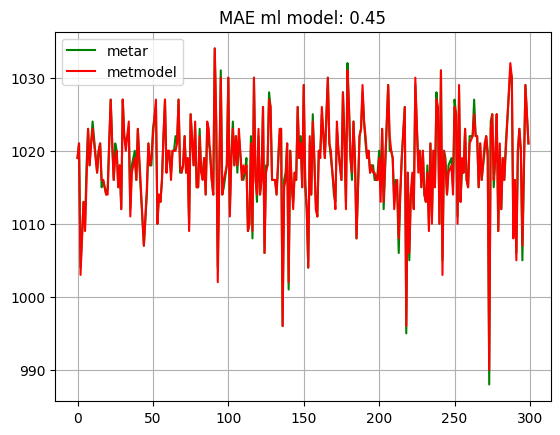

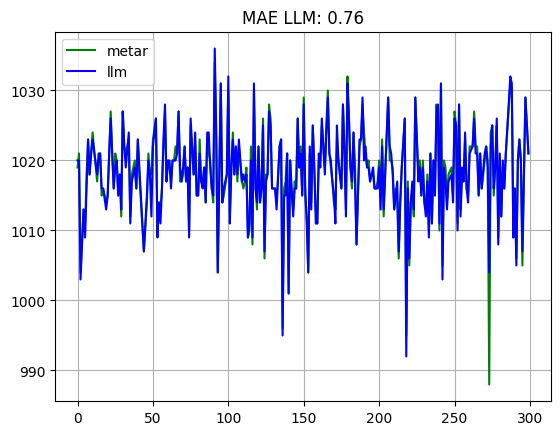

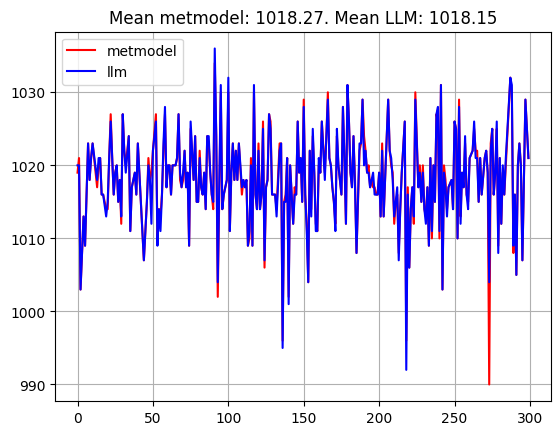

In [3]:
#@title QNH check

import pandas as pd
import numpy as np
pd.options.display.max_rows = 999

score = []

def flatten_list(list_s):
  numbers = []
  for sublist in list_s:
      for item in sublist:
          # Check if the string after 'q' is not empty
          if len(item) > 1:
              num = item[1:]
              if num.isdigit():
                  numbers.append(int(num))


  return np.array(numbers)

df = pd.read_csv(result_path)
q_ytest = []
q_ypred = []
q_metmod =[]
for i in range(0,len(df)):
  q_ytest.append([word for word in df["y_test"][i].split() if 'q' in word.lower()])
  q_ypred.append([word for word in df["y_pred"][i].split() if 'q' in word.lower()][:1])
  q_metmod.append([word for word in df["all"][i].split() if 'q' in word.lower()][:1])

q_ypred_f = []

for sublist in q_ypred:
    if not sublist:  # Check if the sublist is empty
        q_ypred_f.append(["q0000"])
    else:
        q_ypred_f.append(sublist)  # Append the single string element


q_ypred_n = flatten_list(q_ypred_f)
q_test_n = flatten_list(q_ytest)
q_metmod_n = flatten_list(q_metmod)


#Show results
df_res = pd.DataFrame({"metar":q_test_n,"metmodel":q_metmod_n,"llm":q_ypred_n})

#avoid 0
df_res = df_res[df_res.llm!=0]
mae_llm = round((df_res['metar'] - df_res['llm']).abs().mean(),2)
mae_metmod = round(np.mean(np.abs(q_metmod_n - q_test_n)),2)

score.append(mae_llm)
score.append(mae_metmod)

df_res[["metar","metmodel"]].plot(grid=True, color=['green', 'red'],title="MAE ml model: {}".format(mae_metmod));
df_res[["metar","llm"]].plot(grid=True, color=['green', 'blue'],title="MAE LLM: {}".format(mae_llm));
df_res[["metmodel","llm"]].plot(grid=True, color=['red', 'blue'],title="Mean metmodel: {}. Mean LLM: {}".format(round(q_metmod_n.mean(),2),round(df_res.llm.mean(),2)));

In [4]:
#@title wind check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.options.display.max_rows = 999

def contains_vrb(column):
    return column.str.contains('VRB', case=False, na=False)

def detect_wind_variation_test(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})V(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1

def detect_wind_variation_llm(metar):
    # Define a regex pattern for wind direction variation
    wind_variation_pattern = r'\b(\d{3})v(\d{3})\b'

    # Search for the wind direction variation in the METAR report
    match = re.search(wind_variation_pattern, metar)
    if match:
        dir1 = match.group(1)
        dir2 = match.group(2)
        return dir1,dir2
    else:
        return -1,-1


# Function to extract wind direction, speed, and gusts
def extract_wind_llm(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(vrb|\d{3})(\d{2})(g\d{2})?kt\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"


def extract_wind_test(metar):
    # Define a regex pattern for wind direction, intensity, and gusts
    # Also include a pattern for variable wind direction (VRB)
    wind_pattern = r'\b(VRB|\d{3})(\d{2})(G\d{2})?KT\b'

    # Search for the wind information in the METAR report
    match = re.search(wind_pattern, metar)
    if match:
        wind_direction = match.group(1)
        wind_speed = match.group(2)
        wind_gust = match.group(3) if match.group(3) else 0
        return wind_direction, wind_speed, wind_gust
    else:
        return "Wind information not found"

dirtest, modtest, gtest =[],[],[]
dirllm, modllm, gllm =[],[],[]

df = pd.read_csv(result_path)

for i in range(0,len(df)):
  wind_info_test = extract_wind_test(df["y_test"][i])
  wind_info_llm = extract_wind_llm(df["y_pred"][i])

  if isinstance(wind_info_test, tuple):
    dir, mod, gust = wind_info_test
    dirtest.append(dir)
    modtest.append(mod)
    gtest.append(gust)

  else:
    print(wind_info_test)
    dirtest.append(np.nan)
    modtest.append(np.nan)
    gtest.append(np.nan)

  if isinstance(wind_info_llm, tuple):
    dir, mod, gust = wind_info_llm
    dirllm.append(dir)
    modllm.append(mod)
    gllm.append(gust)

  else:
    print(wind_info_llm,i)
    dirllm.append(np.nan)
    modllm.append(np.nan)
    gllm.append(np.nan)

df["dirtest"]=dirtest
df["modtest"]=modtest
df["gtest"]=gtest

df["dirllm"]=dirllm
df["modllm"]=modllm
df["gllm"]=gllm

for i in range(0,len(df)):
  if "G" in str(df['gtest'][i]):
    df["gtest"][i]= int(df['gtest'][i][1:])

for i in range(0,len(df)):
  if "g" in str(df['gllm'][i]):
    df["gllm"][i]= int(df['gllm'][i][1:])

dirmetmod =[]
for i in range(0,len(df)):
  dirmetmod.append(int(df["all"][i].split()[0][:3]))
df["dirmetmod"] = dirmetmod

modmetmod =[]
for i in range(0,len(df)):
  modmetmod.append(int(df["all"][i].split()[0][3:5]))
df["modmetmod"] = modmetmod

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_test(df["y_test"][i]))
df["dirvartest"] = dirvar

dirvar = []
for i in range(0,len(df)):
  dirvar.append(detect_wind_variation_llm(df["y_pred"][i]))
df["dirvarllm"] = dirvar
df.set_index("time")

#Analytics
mask_dirtest = contains_vrb(df['dirtest'])
mask_dirllm = contains_vrb(df['dirllm'])

# Combine the masks to filter rows
df_dir = df[~(mask_dirtest | mask_dirllm)][["dirtest","dirllm","dirmetmod"]].dropna().astype(int)

mae = int(np.mean(np.abs(df_dir['dirtest'] - df_dir['dirmetmod'])))
print(f"Mean Absolute Error (degrees) wind direction metmodel and metar: {mae}")
score.append(mae)
#MAE dir no vrb llm metar
mae = int((np.mean(np.abs(df_dir['dirtest'] - df_dir['dirllm']))))
print(f"Mean Absolute Error (degrees) wind direction llm and metar: {mae}")
score.append(mae)
df_mod= df[['modmetmod',"modtest","modllm"]].dropna().astype(int)

mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modmetmod'])),2)
print(f"Mean Absolute Error (Kt) wind intensity metmodel and metar: {mae}")
score.append(mae)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_mod['modtest'] - df_mod['modllm'])),2)
print(f"Mean Absolute Error (kt) wind intensity llm and metar: {mae}")
score.append(mae)

dirvary = sum([1 if (df["dirvarllm"][c][0]!=-1) & (df["dirvartest"][c][0]!=-1) else 0 for c in range(0,len(df))])
dirvarn = sum([1 if (df["dirvarllm"][c][0]==-1) & (df["dirvartest"][c][0]==-1) else 0 for c in range(0,len(df))])
print("Both metar and forecast direction variation:", round(dirvary/len(df),2))
print("Both metar and forecast no direction variation:",round(dirvarn/len(df),2))
print("No match between metar and forecast:", round((len(df)-dirvary-dirvarn)/len(df),2))

display(df.set_index("time")[["dirtest","dirllm","dirmetmod","dirvartest","dirvarllm", "modtest",	"modmetmod","modllm","gtest","gllm"]].head(20))

Mean Absolute Error (degrees) wind direction metmodel and metar: 62
Mean Absolute Error (degrees) wind direction llm and metar: 59
Mean Absolute Error (Kt) wind intensity metmodel and metar: 2.92
Mean Absolute Error (kt) wind intensity llm and metar: 2.31
Both metar and forecast direction variation: 0.46
Both metar and forecast no direction variation: 0.17
No match between metar and forecast: 0.37


,dirtest,dirllm,dirmetmod,dirvartest,dirvarllm,modtest,modmetmod,modllm,gtest,gllm
time,,,,,,,,,,
2021-08-03 21:00:00,240,270,280,"(150, 290)","(240, 310)",05,3,06,16,0
2021-10-08 12:00:00,VRB,260,260,"(-1, -1)","(230, 310)",03,5,06,0,0
2022-04-10 23:00:00,190,220,130,"(120, 220)","(-1, -1)",07,9,06,0,0
2022-01-05 11:00:00,180,220,230,"(120, 230)","(180, 260)",06,9,09,0,0
2020-04-27 10:00:00,180,vrb,260,"(100, 230)","(-1, -1)",04,7,07,0,0
2022-12-02 18:00:00,240,vrb,100,"(200, 280)","(-1, -1)",04,1,02,0,0
2019-04-19 19:00:00,090,vrb,70,"(060, 120)","(-1, -1)",09,13,03,0,0
2020-05-18 23:00:00,360,vrb,10,"(320, 020)","(-1, -1)",04,5,02,0,0
2022-07-21 21:00:00,020,030,10,"(-1, -1)","(350, 060)",05,11,06,0,0


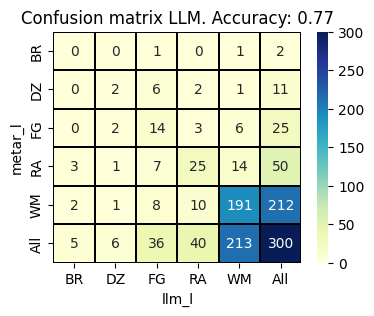

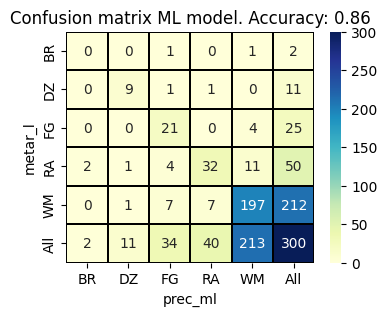

In [5]:
#@title wx check

from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
df = pd.read_csv(result_path)

#label br/fg if weather code contains FG or BR
df["metar_l"] = "WM"
mask = df['y_test'].str.contains("BR")
df.loc[mask,["metar_l"]] = "BR"
mask = df['y_test'].str.contains("FG")
df.loc[mask,["metar_l"]] = "FG"
mask = df['y_test'].str.contains("DZ")
df.loc[mask,["metar_l"]] = "DZ"
mask = df['y_test'].str.contains("RA")
df.loc[mask,["metar_l"]] = "RA"

df["llm_l"] = "WM"
mask = df['y_pred'].str.contains("br")
df.loc[mask,["llm_l"]] = "BR"
mask = df['y_pred'].str.contains("fg")
df.loc[mask,["llm_l"]] = "FG"
mask = df['y_pred'].str.contains("dz")
df.loc[mask,["llm_l"]] = "DZ"
mask = df['y_pred'].str.contains("ra")
df.loc[mask,["llm_l"]] = "RA"



prec_ml =[]
for i in range(0,len(df["all"])):
  prec_ml.append(df["all"][i].split()[2])
df["prec_ml"] = prec_ml


# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df.metar_l, df.llm_l,margins=True)

ac0 = round(accuracy_score(df.metar_l,df.llm_l),2)
score.append(ac0)

cm1 = pd.crosstab(df.metar_l, df.prec_ml,margins=True)
ac1 = round(accuracy_score(df.metar_l,df.prec_ml),2)
score.append(ac1)



plt.figure(figsize=(4, 3))
plt.title("Confusion matrix LLM. Accuracy: {}".format(ac0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix ML model. Accuracy: {}".format(ac1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()


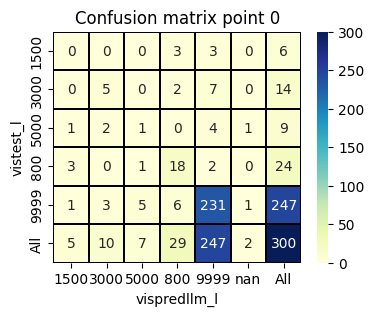


Quality report LLM model
              precision    recall  f1-score  support
1500           0.000000  0.000000  0.000000     6.00
3000           0.500000  0.357143  0.416667    14.00
5000           0.142857  0.111111  0.125000     9.00
800            0.620690  0.750000  0.679245    24.00
9999           0.935223  0.935223  0.935223   247.00
nan            0.000000  0.000000  0.000000     0.00
accuracy       0.850000  0.850000  0.850000     0.85
macro avg      0.366462  0.358913  0.359356   300.00
weighted avg   0.847274  0.850000  0.847534   300.00
accuracy: 0.85


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

In [6]:
#@title Visibility check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

pd.options.display.max_rows = 999

def extract_visibility(metar):
    # Check if 'CAVOK' is in the METAR report
    if 'CAVOK' in metar:
        return 9999
    if "cavok" in metar:
        return 9999
    # Define a regex pattern for visibility
    visibility_pattern = r'\b(\d{4}|(\d+/\d+)?SM)\b'

    # Search for the visibility in the METAR report
    match = re.search(visibility_pattern, metar)
    if match:
        return int(match.group(0))
    else:
        return "Visibility information not found"

df = pd.read_csv(result_path)

vistest = []
vispred = []
for i in range(0,len(df)):
  vistest.append(extract_visibility(df["y_test"][i]))
  vispred.append(extract_visibility(df["y_pred"][i]))

df["vistest"]= vistest
df["vispred"]= vispred
df[['y_test', 'y_pred', 'all', 'vistest', 'vispred']]


#visibility to interval
interval = pd.IntervalIndex.from_tuples([(-0.1,800), (800, 1500),(1500,3000),(3000,5000),(5000,100000)])
labels = ['800', '1500',"3000","5000","9999"]

df["vistest_l"] = pd.cut(df["vistest"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
df["vispredllm_l"] = pd.cut(df["vispred"], bins=interval,retbins=False,
                        labels=labels).map({a:b for a,b in zip(interval,labels)}).astype(str)
df =df.dropna()
cm0 = pd.crosstab(df.vistest_l, df.vispredllm_l,margins=True)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0")
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

report = classification_report(df.vistest_l,df.vispredllm_l, output_dict=True)

# Convert to DataFrame for easier manipulation (optional)
report_df = pd.DataFrame(report).transpose()

# Extract accuracy
accuracy = report['accuracy']

report = pd.DataFrame(classification_report(df.vistest_l,df.vispredllm_l,output_dict=True)).T
print("\nQuality report LLM model")
print(report)
print("accuracy:",accuracy)
score.append(accuracy)

In [7]:
#@title Temperature check

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def extract_temperature_test(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(M?\d{2})/(M?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'M' in temperature:
            temperature = -int(temperature.replace('M', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


def extract_temperature_llm(metar):
    # Define a regex pattern to match the temperature (TT/DD)
    temperature_pattern = r'\b(m?\d{2}) (m?\d{2})\b'

    # Search for the temperature pattern in the METAR report
    match = re.search(temperature_pattern, metar)
    if match:
        temperature = match.group(1)
        if 'm' in temperature:
            temperature = -int(temperature.replace('m', ''))
        else:
            temperature = int(temperature)
        return temperature
    else:
        return None


templlm,tempmetar,tempmetmod, tempmetmodraw =[],[],[],[]
for i in range (0,len(df)):
  tempmetar.append(extract_temperature_test(df["y_test"][i]))
  templlm.append(extract_temperature_llm(df["y_pred"][i]))
  tempmetmodraw.append(df["all"][i].split()[5])

tempmetmod = [-int(temperature.replace('M', '')) if 'M' in temperature else int(temperature) for temperature in tempmetmodraw]
df_temp=pd.DataFrame({"tempmetar":tempmetar,"templlm":templlm,"tempmetmod":tempmetmod}).dropna()


mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['tempmetmod'])),2)
std = round((df_temp['tempmetar'] - df_temp['tempmetmod']).std(),2)
print(f"Mean Absolute Error (degrees) temperature metmodel and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature metmodel and metar: {std}")
score.append(mae)
score.append(std)

#MAE dir no vrb llm metar
mae = round(np.mean(np.abs(df_temp['tempmetar'] - df_temp['templlm'])),2)
std = round((df_temp['tempmetar'] - df_temp['templlm']).std(),2)
print(f"Mean Absolute Error temperature (degreees) llm and metar: {mae}")
print(f"Standard desviation differences (degrees) temperature LLM and metar: {std}")
score.append(mae)
score.append(std)
df_temp.head(20)

Mean Absolute Error (degrees) temperature metmodel and metar: 0.8
Standard desviation differences (degrees) temperature metmodel and metar: 1.16
Mean Absolute Error temperature (degreees) llm and metar: 1.24
Standard desviation differences (degrees) temperature LLM and metar: 2.44


,tempmetar,templlm,tempmetmod
0,18,18.0,18
1,24,23.0,24
2,12,9.0,11
4,11,12.0,12
5,8,7.0,9
6,20,21.0,20
7,15,15.0,15
8,21,23.0,23
9,25,30.0,28
10,19,19.0,20


In [8]:
#@title Save score

df_score = pd.DataFrame(score,index=["MAE_QNH_llm","MAE_QNH_ml","MAE_dir_metmodel",
                          "MAE_dir_llm","MAE_wind_int_metmodel","MAE_wind_int_llm",
                          "Aaccuracy_wx_llm","Accuracy_wx_ML","accuracy_vis_llm","MAE_temp_ml","Std_temp_diff_ml",
                          "MAE_temp_llm","Std_temp_diff_llm"], columns=["Score"])
score_path = "/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/LEVXmlscore.csv"
df_score.to_csv(score_path)

In [9]:
df_score

,Score
MAE_QNH_llm,0.76
MAE_QNH_ml,0.45
MAE_dir_metmodel,62.00
MAE_dir_llm,59.00
MAE_wind_int_metmodel,2.92
MAE_wind_int_llm,2.31
Aaccuracy_wx_llm,0.77
Accuracy_wx_ML,0.86
accuracy_vis_llm,0.85
MAE_temp_ml,0.80
